# Susceptibility to substitution

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES = ['frequency', 'aoa', 'clustering', 'letters_count',
                  'synonyms_count', 'orthographic_density']
BIN_COUNT = 4

Imports and database setup.

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from statsmodels.stats.proportion import multinomial_proportions_confint

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope, stopwords
engine = init_db()

Build our data.

In [3]:
def qposition(values, position):
    value = values[position]
    if np.isnan(value):
        return np.nan, np.nan
    finite_values = values[np.isfinite(values)]
    svalues = np.array(sorted(finite_values))
    length = len(svalues)
    ours = np.where(svalues == value)[0]
    return ours[0] / length, (ours[-1] + 1) / length

In [4]:
model = Model(time=Time.continuous, source=Source.all, past=Past.all, durl=Durl.all, max_distance=1)
stop_poses = ['C', 'F', 'I', 'M', 'P', 'S', 'U']

data = []

# First get the exact substitution ids so we can get a working progress bar
# in the next step.
with session_scope() as session:
    substitutions = session.query(Substitution.id)\
        .filter(Substitution.model == model)
    print("Got {} substitutions for model {}"
          .format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        # Prepare these arrays for use in stopword-checking.
        dslice = slice(substitution.start,
                       substitution.start
                       + len(substitution.destination.tokens))
        lemmas = substitution.source.lemmas[dslice]
        tokens = substitution.source.tokens[dslice]
        tags = substitution.source.tags[dslice]
        is_stopword = np.array([(lemma in stopwords)
                                or (token in stopwords)
                                for (lemma, token) in zip(lemmas, tokens)])
        
        for feature in Substitution.__features__:
            
            # Get feature values for the sentence and its words.
            sentence_values, _ = substitution.\
                source_destination_features(feature)
            sentence_values_rel, _ = substitution.\
                source_destination_features(feature,
                                            sentence_relative='median')
            source_type, _ = Substitution.__features__[feature]
            words = getattr(substitution.source, source_type)[dslice]
            
            # Find the bins we'll use.
            # If there are only NaNs or only one feature value
            # we can't get bins on this sentence, so we want at least
            # 2 different feature values.
            # We also skip feature values if the source word is not coded
            # for the feature, as it would skew the 'appeared' 
            # distributions compared to the distribution of substituted
            # words. (For instance, the sum of categories would not be 
            # equal to the sum of H0s in the very last graphs, 
            # on sentencequantile. It also lets us make meaningful H0
            # comparison in all the other feature-based graphs.)
            non_sw_values = sentence_values.copy()
            non_sw_values[is_stopword] = np.nan
            non_sw_value_set = \
                set(non_sw_values[np.isfinite(non_sw_values)])
            if (len(non_sw_value_set) <= 1 or
                    np.isnan(sentence_values[substitution.position])):
                allnans = [np.nan] * len(non_sw_values)
                bins = allnans
                non_sw_values = allnans
                sentence_values = allnans
                sentence_values_rel = allnans
            else:
                bins = pd.cut(non_sw_values, BIN_COUNT, labels=False)
            
            # For each non-stopword, store its various properties.
            for i, (word, tag, skip) in enumerate(zip(words, tags,
                                                      is_stopword)):
                if skip:
                    # Drop any stopwords.
                    continue

                # Get a readable POS tag
                rtag = tag[0]
                rtag = 'Stopword-like' if rtag in stop_poses else rtag
                
                # Get the word's quantile position.
                start_quantile, stop_quantile = qposition(non_sw_values, i)

                # Store the word's properties.
                data.append({
                    'cluster_id': substitution.source.cluster.sid,
                    'destination_id': substitution.destination.sid,
                    'occurrence': substitution.occurrence,
                    'source_id': substitution.source.sid,
                    'position': substitution.position,
                    'feature': feature,
                    'word': word,
                    'POS': tag,
                    'rPOS': rtag,
                    'target': i == substitution.position,
                    'value': sentence_values[i],
                    'value_rel': sentence_values_rel[i],
                    'bin': bins[i],
                    'start_quantile': start_quantile,
                    'stop_quantile': stop_quantile,
                    'word_position': i
                })

words = pd.DataFrame(data)
del data

Got 72339 substitutions for model Model(time=Time.continuous, source=Source.all, past=Past.all, durl=Durl.all, max_distance=1)


  0% (    1 of 72339) |            | Elapsed Time: 0:00:03 ETA:  3 days, 0:29:48

  0% (   82 of 72339) |                    | Elapsed Time: 0:00:04 ETA:  0:14:53

  0% (  153 of 72339) |                    | Elapsed Time: 0:00:05 ETA:  0:15:52

  0% (  237 of 72339) |                    | Elapsed Time: 0:00:06 ETA:  0:15:19

  0% (  322 of 72339) |                    | Elapsed Time: 0:00:07 ETA:  0:14:59

  0% (  407 of 72339) |                    | Elapsed Time: 0:00:08 ETA:  0:14:47

  0% (  490 of 72339) |                    | Elapsed Time: 0:00:09 ETA:  0:14:43

  0% (  576 of 72339) |                    | Elapsed Time: 0:00:10 ETA:  0:14:35

  0% (  659 of 72339) |                    | Elapsed Time: 0:00:11 ETA:  0:14:32

  1% (  741 of 72339) |                    | Elapsed Time: 0:00:12 ETA:  0:14:32

  1% (  828 of 72339) |                    | Elapsed Time: 0:00:13 ETA:  0:14:24

  1% (  905 of 72339) |                    | Elapsed Time: 0:00:14 ETA:  0:14:04

  1% (  992 of 72339) |                    | Elapsed Time: 0:00:15 ETA:  0:13:59

  1% ( 1080 of 72339) |                    | Elapsed Time: 0:00:16 ETA:  0:13:54

  1% ( 1170 of 72339) |                    | Elapsed Time: 0:00:17 ETA:  0:13:48

  1% ( 1258 of 72339) |                    | Elapsed Time: 0:00:18 ETA:  0:13:41

  1% ( 1348 of 72339) |                    | Elapsed Time: 0:00:19 ETA:  0:13:35

  1% ( 1434 of 72339) |                    | Elapsed Time: 0:00:20 ETA:  0:13:32

  2% ( 1516 of 72339) |                    | Elapsed Time: 0:00:21 ETA:  0:13:30

  2% ( 1610 of 72339) |                    | Elapsed Time: 0:00:22 ETA:  0:13:22

  2% ( 1706 of 72339) |                    | Elapsed Time: 0:00:23 ETA:  0:13:13

  2% ( 1809 of 72339) |                    | Elapsed Time: 0:00:24 ETA:  0:13:09

  2% ( 1902 of 72339) |                    | Elapsed Time: 0:00:25 ETA:  0:13:04

  2% ( 1994 of 72339) |                    | Elapsed Time: 0:00:26 ETA:  0:12:59

  2% ( 2077 of 72339) |                    | Elapsed Time: 0:00:27 ETA:  0:13:05

  2% ( 2159 of 72339) |                    | Elapsed Time: 0:00:28 ETA:  0:13:09

  3% ( 2225 of 72339) |                    | Elapsed Time: 0:00:29 ETA:  0:13:42

  3% ( 2303 of 72339) |                    | Elapsed Time: 0:00:30 ETA:  0:14:01

  3% ( 2384 of 72339) |                    | Elapsed Time: 0:00:31 ETA:  0:14:19

  3% ( 2463 of 72339) |                    | Elapsed Time: 0:00:32 ETA:  0:14:30

  3% ( 2544 of 72339) |                    | Elapsed Time: 0:00:33 ETA:  0:14:31

  3% ( 2623 of 72339) |                    | Elapsed Time: 0:00:34 ETA:  0:14:48

  3% ( 2713 of 72339) |                    | Elapsed Time: 0:00:36 ETA:  0:15:12

  3% ( 2792 of 72339) |                    | Elapsed Time: 0:00:37 ETA:  0:15:15

  3% ( 2867 of 72339) |                    | Elapsed Time: 0:00:38 ETA:  0:14:44

  4% ( 2932 of 72339) |                    | Elapsed Time: 0:00:39 ETA:  0:15:01

  4% ( 2998 of 72339) |                    | Elapsed Time: 0:00:40 ETA:  0:15:23

  4% ( 3067 of 72339) |                    | Elapsed Time: 0:00:41 ETA:  0:15:39

  4% ( 3132 of 72339) |                    | Elapsed Time: 0:00:42 ETA:  0:16:06

  4% ( 3202 of 72339) |                    | Elapsed Time: 0:00:43 ETA:  0:16:20

  4% ( 3280 of 72339) |                    | Elapsed Time: 0:00:44 ETA:  0:16:22

  4% ( 3357 of 72339) |                    | Elapsed Time: 0:00:45 ETA:  0:16:12

  4% ( 3433 of 72339) |                    | Elapsed Time: 0:00:46 ETA:  0:16:16

  4% ( 3512 of 72339) |                    | Elapsed Time: 0:00:47 ETA:  0:16:08

  4% ( 3591 of 72339) |                    | Elapsed Time: 0:00:48 ETA:  0:15:46

  5% ( 3617 of 72339) |#                   | Elapsed Time: 0:00:48 ETA:  0:15:29

  5% ( 3709 of 72339) |#                   | Elapsed Time: 0:00:49 ETA:  0:14:53

  5% ( 3787 of 72339) |#                   | Elapsed Time: 0:00:50 ETA:  0:14:32

  5% ( 3864 of 72339) |#                   | Elapsed Time: 0:00:51 ETA:  0:14:22

  5% ( 3943 of 72339) |#                   | Elapsed Time: 0:00:52 ETA:  0:14:19

  5% ( 4023 of 72339) |#                   | Elapsed Time: 0:00:53 ETA:  0:14:14

  5% ( 4104 of 72339) |#                   | Elapsed Time: 0:00:54 ETA:  0:14:06

  5% ( 4183 of 72339) |#                   | Elapsed Time: 0:00:55 ETA:  0:14:06

  5% ( 4259 of 72339) |#                   | Elapsed Time: 0:00:56 ETA:  0:14:08

  5% ( 4339 of 72339) |#                   | Elapsed Time: 0:00:57 ETA:  0:14:08

  6% ( 4418 of 72339) |#                   | Elapsed Time: 0:00:58 ETA:  0:14:23

  6% ( 4497 of 72339) |#                   | Elapsed Time: 0:00:59 ETA:  0:14:22

  6% ( 4522 of 72339) |#                   | Elapsed Time: 0:00:59 ETA:  0:14:18

  6% ( 4602 of 72339) |#                   | Elapsed Time: 0:01:00 ETA:  0:14:16

  6% ( 4683 of 72339) |#                   | Elapsed Time: 0:01:01 ETA:  0:14:13

  6% ( 4739 of 72339) |#                   | Elapsed Time: 0:01:02 ETA:  0:14:59

  6% ( 4819 of 72339) |#                   | Elapsed Time: 0:01:03 ETA:  0:14:56

  6% ( 4900 of 72339) |#                   | Elapsed Time: 0:01:04 ETA:  0:14:48

  6% ( 4979 of 72339) |#                   | Elapsed Time: 0:01:05 ETA:  0:14:48

  6% ( 5062 of 72339) |#                   | Elapsed Time: 0:01:07 ETA:  0:14:43

  7% ( 5145 of 72339) |#                   | Elapsed Time: 0:01:08 ETA:  0:14:35

  7% ( 5231 of 72339) |#                   | Elapsed Time: 0:01:09 ETA:  0:14:23

  7% ( 5316 of 72339) |#                   | Elapsed Time: 0:01:10 ETA:  0:14:16

  7% ( 5384 of 72339) |#                   | Elapsed Time: 0:01:11 ETA:  0:14:34

  7% ( 5426 of 72339) |#                   | Elapsed Time: 0:01:11 ETA:  0:14:13

  7% ( 5483 of 72339) |#                   | Elapsed Time: 0:01:12 ETA:  0:14:45

  7% ( 5543 of 72339) |#                   | Elapsed Time: 0:01:13 ETA:  0:15:15

  7% ( 5600 of 72339) |#                   | Elapsed Time: 0:01:14 ETA:  0:15:49

  7% ( 5660 of 72339) |#                   | Elapsed Time: 0:01:15 ETA:  0:16:27

  7% ( 5719 of 72339) |#                   | Elapsed Time: 0:01:16 ETA:  0:17:12

  7% ( 5783 of 72339) |#                   | Elapsed Time: 0:01:17 ETA:  0:17:55

  8% ( 5871 of 72339) |#                   | Elapsed Time: 0:01:18 ETA:  0:17:47

  8% ( 5936 of 72339) |#                   | Elapsed Time: 0:01:19 ETA:  0:17:52

  8% ( 6007 of 72339) |#                   | Elapsed Time: 0:01:20 ETA:  0:17:28

  8% ( 6075 of 72339) |#                   | Elapsed Time: 0:01:21 ETA:  0:17:07

  8% ( 6151 of 72339) |#                   | Elapsed Time: 0:01:22 ETA:  0:16:36

  8% ( 6249 of 72339) |#                   | Elapsed Time: 0:01:23 ETA:  0:15:28

  8% ( 6330 of 72339) |#                   | Elapsed Time: 0:01:24 ETA:  0:14:52

  8% ( 6412 of 72339) |#                   | Elapsed Time: 0:01:25 ETA:  0:14:17

  8% ( 6494 of 72339) |#                   | Elapsed Time: 0:01:26 ETA:  0:13:53

  9% ( 6578 of 72339) |#                   | Elapsed Time: 0:01:27 ETA:  0:13:57

  9% ( 6661 of 72339) |#                   | Elapsed Time: 0:01:28 ETA:  0:13:32

  9% ( 6744 of 72339) |#                   | Elapsed Time: 0:01:29 ETA:  0:13:17

  9% ( 6818 of 72339) |#                   | Elapsed Time: 0:01:30 ETA:  0:13:09

  9% ( 6887 of 72339) |#                   | Elapsed Time: 0:01:31 ETA:  0:13:17

  9% ( 6989 of 72339) |#                   | Elapsed Time: 0:01:32 ETA:  0:13:10

  9% ( 7080 of 72339) |#                   | Elapsed Time: 0:01:33 ETA:  0:13:00

  9% ( 7174 of 72339) |#                   | Elapsed Time: 0:01:34 ETA:  0:12:46

 10% ( 7234 of 72339) |##                  | Elapsed Time: 0:01:35 ETA:  0:12:46

 10% ( 7313 of 72339) |##                  | Elapsed Time: 0:01:36 ETA:  0:12:51

 10% ( 7397 of 72339) |##                  | Elapsed Time: 0:01:37 ETA:  0:12:49

 10% ( 7482 of 72339) |##                  | Elapsed Time: 0:01:38 ETA:  0:12:45

 10% ( 7566 of 72339) |##                  | Elapsed Time: 0:01:39 ETA:  0:12:32

 10% ( 7610 of 72339) |##                  | Elapsed Time: 0:01:40 ETA:  0:12:59

 10% ( 7692 of 72339) |##                  | Elapsed Time: 0:01:41 ETA:  0:13:24

 10% ( 7772 of 72339) |##                  | Elapsed Time: 0:01:42 ETA:  0:13:38

 10% ( 7855 of 72339) |##                  | Elapsed Time: 0:01:43 ETA:  0:13:52

 10% ( 7939 of 72339) |##                  | Elapsed Time: 0:01:44 ETA:  0:13:44

 11% ( 8022 of 72339) |##                  | Elapsed Time: 0:01:45 ETA:  0:13:38

 11% ( 8105 of 72339) |##                  | Elapsed Time: 0:01:46 ETA:  0:13:38

 11% ( 8139 of 72339) |##                  | Elapsed Time: 0:01:47 ETA:  0:13:43

 11% ( 8224 of 72339) |##                  | Elapsed Time: 0:01:48 ETA:  0:13:41

 11% ( 8309 of 72339) |##                  | Elapsed Time: 0:01:49 ETA:  0:12:47

 11% ( 8393 of 72339) |##                  | Elapsed Time: 0:01:50 ETA:  0:12:43

 11% ( 8478 of 72339) |##                  | Elapsed Time: 0:01:51 ETA:  0:12:35

 11% ( 8561 of 72339) |##                  | Elapsed Time: 0:01:52 ETA:  0:12:34

 11% ( 8644 of 72339) |##                  | Elapsed Time: 0:01:53 ETA:  0:12:34

 12% ( 8729 of 72339) |##                  | Elapsed Time: 0:01:54 ETA:  0:12:30

 12% ( 8813 of 72339) |##                  | Elapsed Time: 0:01:55 ETA:  0:12:28

 12% ( 8896 of 72339) |##                  | Elapsed Time: 0:01:56 ETA:  0:12:28

 12% ( 8980 of 72339) |##                  | Elapsed Time: 0:01:57 ETA:  0:12:29

 12% ( 9043 of 72339) |##                  | Elapsed Time: 0:01:57 ETA:  0:12:27

 12% ( 9127 of 72339) |##                  | Elapsed Time: 0:01:58 ETA:  0:12:27

 12% ( 9214 of 72339) |##                  | Elapsed Time: 0:01:59 ETA:  0:12:23

 12% ( 9305 of 72339) |##                  | Elapsed Time: 0:02:00 ETA:  0:12:14

 12% ( 9394 of 72339) |##                  | Elapsed Time: 0:02:01 ETA:  0:12:05

 13% ( 9485 of 72339) |##                  | Elapsed Time: 0:02:02 ETA:  0:11:58

 13% ( 9577 of 72339) |##                  | Elapsed Time: 0:02:03 ETA:  0:11:48

 13% ( 9670 of 72339) |##                  | Elapsed Time: 0:02:05 ETA:  0:11:36

 13% ( 9759 of 72339) |##                  | Elapsed Time: 0:02:06 ETA:  0:11:30

 13% ( 9848 of 72339) |##                  | Elapsed Time: 0:02:07 ETA:  0:11:27

 13% ( 9947 of 72339) |##                  | Elapsed Time: 0:02:08 ETA:  0:11:21

 13% (10034 of 72339) |##                  | Elapsed Time: 0:02:09 ETA:  0:11:24

 13% (10125 of 72339) |##                  | Elapsed Time: 0:02:10 ETA:  0:11:21

 14% (10216 of 72339) |##                  | Elapsed Time: 0:02:11 ETA:  0:11:20

 14% (10307 of 72339) |##                  | Elapsed Time: 0:02:12 ETA:  0:11:20

 14% (10398 of 72339) |##                  | Elapsed Time: 0:02:13 ETA:  0:11:21

 14% (10486 of 72339) |##                  | Elapsed Time: 0:02:14 ETA:  0:11:20

 14% (10564 of 72339) |##                  | Elapsed Time: 0:02:15 ETA:  0:11:31

 14% (10643 of 72339) |##                  | Elapsed Time: 0:02:16 ETA:  0:11:39

 14% (10722 of 72339) |##                  | Elapsed Time: 0:02:17 ETA:  0:11:46

 14% (10800 of 72339) |##                  | Elapsed Time: 0:02:18 ETA:  0:11:55

 15% (10851 of 72339) |###                 | Elapsed Time: 0:02:18 ETA:  0:12:07

 15% (10927 of 72339) |###                 | Elapsed Time: 0:02:19 ETA:  0:12:24

 15% (11004 of 72339) |###                 | Elapsed Time: 0:02:20 ETA:  0:12:42

 15% (11082 of 72339) |###                 | Elapsed Time: 0:02:21 ETA:  0:12:59

 15% (11161 of 72339) |###                 | Elapsed Time: 0:02:22 ETA:  0:13:10

 15% (11243 of 72339) |###                 | Elapsed Time: 0:02:23 ETA:  0:13:05

 15% (11325 of 72339) |###                 | Elapsed Time: 0:02:24 ETA:  0:13:00

 15% (11410 of 72339) |###                 | Elapsed Time: 0:02:25 ETA:  0:12:52

 15% (11457 of 72339) |###                 | Elapsed Time: 0:02:27 ETA:  0:13:48

 15% (11537 of 72339) |###                 | Elapsed Time: 0:02:28 ETA:  0:13:42

 16% (11623 of 72339) |###                 | Elapsed Time: 0:02:29 ETA:  0:13:28

 16% (11706 of 72339) |###                 | Elapsed Time: 0:02:30 ETA:  0:13:18

 16% (11756 of 72339) |###                 | Elapsed Time: 0:02:30 ETA:  0:13:11

 16% (11840 of 72339) |###                 | Elapsed Time: 0:02:31 ETA:  0:13:03

 16% (11924 of 72339) |###                 | Elapsed Time: 0:02:32 ETA:  0:12:58

 16% (12008 of 72339) |###                 | Elapsed Time: 0:02:33 ETA:  0:12:54

 16% (12091 of 72339) |###                 | Elapsed Time: 0:02:34 ETA:  0:12:54

 16% (12177 of 72339) |###                 | Elapsed Time: 0:02:35 ETA:  0:11:49

 16% (12262 of 72339) |###                 | Elapsed Time: 0:02:36 ETA:  0:11:42

 17% (12346 of 72339) |###                 | Elapsed Time: 0:02:37 ETA:  0:11:43

 17% (12432 of 72339) |###                 | Elapsed Time: 0:02:38 ETA:  0:11:38

 17% (12517 of 72339) |###                 | Elapsed Time: 0:02:39 ETA:  0:11:38

 17% (12603 of 72339) |###                 | Elapsed Time: 0:02:40 ETA:  0:11:35

 17% (12660 of 72339) |###                 | Elapsed Time: 0:02:41 ETA:  0:11:34

 17% (12744 of 72339) |###                 | Elapsed Time: 0:02:42 ETA:  0:11:33

 17% (12830 of 72339) |###                 | Elapsed Time: 0:02:43 ETA:  0:11:29

 17% (12917 of 72339) |###                 | Elapsed Time: 0:02:44 ETA:  0:11:28

 17% (13003 of 72339) |###                 | Elapsed Time: 0:02:45 ETA:  0:11:26

 18% (13090 of 72339) |###                 | Elapsed Time: 0:02:46 ETA:  0:11:22

 18% (13177 of 72339) |###                 | Elapsed Time: 0:02:47 ETA:  0:11:19

 18% (13264 of 72339) |###                 | Elapsed Time: 0:02:48 ETA:  0:11:16

 18% (13351 of 72339) |###                 | Elapsed Time: 0:02:49 ETA:  0:11:14

 18% (13438 of 72339) |###                 | Elapsed Time: 0:02:50 ETA:  0:11:11

 18% (13525 of 72339) |###                 | Elapsed Time: 0:02:51 ETA:  0:11:06

 18% (13564 of 72339) |###                 | Elapsed Time: 0:02:51 ETA:  0:11:05

 18% (13651 of 72339) |###                 | Elapsed Time: 0:02:52 ETA:  0:11:03

 18% (13737 of 72339) |###                 | Elapsed Time: 0:02:53 ETA:  0:11:02

 19% (13824 of 72339) |###                 | Elapsed Time: 0:02:54 ETA:  0:11:00

 19% (13911 of 72339) |###                 | Elapsed Time: 0:02:55 ETA:  0:11:00

 19% (13997 of 72339) |###                 | Elapsed Time: 0:02:56 ETA:  0:11:01

 19% (14085 of 72339) |###                 | Elapsed Time: 0:02:57 ETA:  0:10:59

 19% (14172 of 72339) |###                 | Elapsed Time: 0:02:58 ETA:  0:10:58

 19% (14260 of 72339) |###                 | Elapsed Time: 0:02:59 ETA:  0:10:56

 19% (14348 of 72339) |###                 | Elapsed Time: 0:03:00 ETA:  0:10:54

 19% (14434 of 72339) |###                 | Elapsed Time: 0:03:01 ETA:  0:10:54

 20% (14468 of 72339) |####                | Elapsed Time: 0:03:02 ETA:  0:10:54

 20% (14552 of 72339) |####                | Elapsed Time: 0:03:03 ETA:  0:10:57

 20% (14636 of 72339) |####                | Elapsed Time: 0:03:04 ETA:  0:10:59

 20% (14719 of 72339) |####                | Elapsed Time: 0:03:05 ETA:  0:11:01

 20% (14803 of 72339) |####                | Elapsed Time: 0:03:06 ETA:  0:11:05

 20% (14888 of 72339) |####                | Elapsed Time: 0:03:07 ETA:  0:11:06

 20% (14973 of 72339) |####                | Elapsed Time: 0:03:08 ETA:  0:11:08

 20% (15063 of 72339) |####                | Elapsed Time: 0:03:09 ETA:  0:11:04

 20% (15154 of 72339) |####                | Elapsed Time: 0:03:10 ETA:  0:10:57

 21% (15243 of 72339) |####                | Elapsed Time: 0:03:11 ETA:  0:10:53

 21% (15331 of 72339) |####                | Elapsed Time: 0:03:12 ETA:  0:10:47

 21% (15373 of 72339) |####                | Elapsed Time: 0:03:12 ETA:  0:10:42

 21% (15464 of 72339) |####                | Elapsed Time: 0:03:13 ETA:  0:10:32

 21% (15551 of 72339) |####                | Elapsed Time: 0:03:14 ETA:  0:10:27

 21% (15639 of 72339) |####                | Elapsed Time: 0:03:15 ETA:  0:10:23

 21% (15723 of 72339) |####                | Elapsed Time: 0:03:16 ETA:  0:10:24

 21% (15806 of 72339) |####                | Elapsed Time: 0:03:17 ETA:  0:10:31

 21% (15869 of 72339) |####                | Elapsed Time: 0:03:18 ETA:  0:11:03

 22% (15936 of 72339) |####                | Elapsed Time: 0:03:19 ETA:  0:11:30

 22% (15999 of 72339) |####                | Elapsed Time: 0:03:20 ETA:  0:12:04

 22% (16065 of 72339) |####                | Elapsed Time: 0:03:21 ETA:  0:12:27

 22% (16128 of 72339) |####                | Elapsed Time: 0:03:22 ETA:  0:13:07

 22% (16188 of 72339) |####                | Elapsed Time: 0:03:24 ETA:  0:15:00

 22% (16249 of 72339) |####                | Elapsed Time: 0:03:25 ETA:  0:15:48

 22% (16277 of 72339) |####                | Elapsed Time: 0:03:26 ETA:  0:16:32

 22% (16338 of 72339) |####                | Elapsed Time: 0:03:27 ETA:  0:17:20

 22% (16405 of 72339) |####                | Elapsed Time: 0:03:28 ETA:  0:17:10

 22% (16479 of 72339) |####                | Elapsed Time: 0:03:29 ETA:  0:16:52

 22% (16547 of 72339) |####                | Elapsed Time: 0:03:30 ETA:  0:16:38

 22% (16619 of 72339) |####                | Elapsed Time: 0:03:31 ETA:  0:16:24

 23% (16689 of 72339) |####                | Elapsed Time: 0:03:32 ETA:  0:16:06

 23% (16755 of 72339) |####                | Elapsed Time: 0:03:33 ETA:  0:14:33

 23% (16847 of 72339) |####                | Elapsed Time: 0:03:34 ETA:  0:13:35

 23% (16915 of 72339) |####                | Elapsed Time: 0:03:35 ETA:  0:13:32

 23% (16992 of 72339) |####                | Elapsed Time: 0:03:36 ETA:  0:13:05

 23% (17074 of 72339) |####                | Elapsed Time: 0:03:37 ETA:  0:12:41

 23% (17154 of 72339) |####                | Elapsed Time: 0:03:38 ETA:  0:12:32

 23% (17181 of 72339) |####                | Elapsed Time: 0:03:38 ETA:  0:12:19

 23% (17263 of 72339) |####                | Elapsed Time: 0:03:39 ETA:  0:12:03

 23% (17345 of 72339) |####                | Elapsed Time: 0:03:40 ETA:  0:11:45

 24% (17429 of 72339) |####                | Elapsed Time: 0:03:41 ETA:  0:11:19

 24% (17513 of 72339) |####                | Elapsed Time: 0:03:42 ETA:  0:11:29

 24% (17598 of 72339) |####                | Elapsed Time: 0:03:43 ETA:  0:11:06

 24% (17683 of 72339) |####                | Elapsed Time: 0:03:44 ETA:  0:10:55

 24% (17767 of 72339) |####                | Elapsed Time: 0:03:45 ETA:  0:10:51

 24% (17852 of 72339) |####                | Elapsed Time: 0:03:46 ETA:  0:10:43

 24% (17936 of 72339) |####                | Elapsed Time: 0:03:47 ETA:  0:10:40

 24% (18020 of 72339) |####                | Elapsed Time: 0:03:48 ETA:  0:10:37

 25% (18085 of 72339) |#####               | Elapsed Time: 0:03:49 ETA:  0:10:32

 25% (18168 of 72339) |#####               | Elapsed Time: 0:03:50 ETA:  0:10:32

 25% (18246 of 72339) |#####               | Elapsed Time: 0:03:51 ETA:  0:10:37

 25% (18320 of 72339) |#####               | Elapsed Time: 0:03:52 ETA:  0:10:49

 25% (18395 of 72339) |#####               | Elapsed Time: 0:03:53 ETA:  0:11:01

 25% (18470 of 72339) |#####               | Elapsed Time: 0:03:54 ETA:  0:11:12

 25% (18544 of 72339) |#####               | Elapsed Time: 0:03:55 ETA:  0:11:26

 25% (18622 of 72339) |#####               | Elapsed Time: 0:03:56 ETA:  0:11:32

 25% (18712 of 72339) |#####               | Elapsed Time: 0:03:57 ETA:  0:11:24

 25% (18806 of 72339) |#####               | Elapsed Time: 0:03:58 ETA:  0:11:10

 26% (18878 of 72339) |#####               | Elapsed Time: 0:03:59 ETA:  0:11:23

 26% (18958 of 72339) |#####               | Elapsed Time: 0:04:00 ETA:  0:11:20

 26% (18989 of 72339) |#####               | Elapsed Time: 0:04:00 ETA:  0:11:12

 26% (19071 of 72339) |#####               | Elapsed Time: 0:04:01 ETA:  0:11:01

 26% (19155 of 72339) |#####               | Elapsed Time: 0:04:02 ETA:  0:10:48

 26% (19241 of 72339) |#####               | Elapsed Time: 0:04:03 ETA:  0:10:32

 26% (19314 of 72339) |#####               | Elapsed Time: 0:04:04 ETA:  0:10:37

 26% (19385 of 72339) |#####               | Elapsed Time: 0:04:05 ETA:  0:11:01

 26% (19457 of 72339) |#####               | Elapsed Time: 0:04:06 ETA:  0:11:32

 26% (19525 of 72339) |#####               | Elapsed Time: 0:04:07 ETA:  0:11:36

 27% (19619 of 72339) |#####               | Elapsed Time: 0:04:08 ETA:  0:11:15

 27% (19698 of 72339) |#####               | Elapsed Time: 0:04:09 ETA:  0:11:14

 27% (19775 of 72339) |#####               | Elapsed Time: 0:04:10 ETA:  0:11:21

 27% (19853 of 72339) |#####               | Elapsed Time: 0:04:11 ETA:  0:11:27

 27% (19894 of 72339) |#####               | Elapsed Time: 0:04:12 ETA:  0:11:40

 27% (19966 of 72339) |#####               | Elapsed Time: 0:04:13 ETA:  0:11:40

 27% (20036 of 72339) |#####               | Elapsed Time: 0:04:14 ETA:  0:11:41

 27% (20126 of 72339) |#####               | Elapsed Time: 0:04:15 ETA:  0:11:13

 27% (20219 of 72339) |#####               | Elapsed Time: 0:04:16 ETA:  0:10:39

 28% (20311 of 72339) |#####               | Elapsed Time: 0:04:17 ETA:  0:10:40

 28% (20396 of 72339) |#####               | Elapsed Time: 0:04:18 ETA:  0:10:32

 28% (20483 of 72339) |#####               | Elapsed Time: 0:04:19 ETA:  0:10:18

 28% (20569 of 72339) |#####               | Elapsed Time: 0:04:20 ETA:  0:10:07

 28% (20641 of 72339) |#####               | Elapsed Time: 0:04:21 ETA:  0:10:15

 28% (20726 of 72339) |#####               | Elapsed Time: 0:04:22 ETA:  0:09:59

 28% (20798 of 72339) |#####               | Elapsed Time: 0:04:23 ETA:  0:09:37

 28% (20885 of 72339) |#####               | Elapsed Time: 0:04:24 ETA:  0:09:39

 28% (20955 of 72339) |#####               | Elapsed Time: 0:04:25 ETA:  0:10:06

 29% (21019 of 72339) |#####               | Elapsed Time: 0:04:26 ETA:  0:10:39

 29% (21090 of 72339) |#####               | Elapsed Time: 0:04:27 ETA:  0:10:55

 29% (21161 of 72339) |#####               | Elapsed Time: 0:04:28 ETA:  0:11:16

 29% (21230 of 72339) |#####               | Elapsed Time: 0:04:29 ETA:  0:11:39

 29% (21300 of 72339) |#####               | Elapsed Time: 0:04:30 ETA:  0:11:40

 29% (21384 of 72339) |#####               | Elapsed Time: 0:04:31 ETA:  0:11:40

 29% (21469 of 72339) |#####               | Elapsed Time: 0:04:32 ETA:  0:11:43

 29% (21489 of 72339) |#####               | Elapsed Time: 0:04:33 ETA:  0:13:35

 29% (21573 of 72339) |#####               | Elapsed Time: 0:04:34 ETA:  0:13:08

 29% (21659 of 72339) |#####               | Elapsed Time: 0:04:35 ETA:  0:12:31

 30% (21702 of 72339) |######              | Elapsed Time: 0:04:35 ETA:  0:12:15

 30% (21793 of 72339) |######              | Elapsed Time: 0:04:36 ETA:  0:11:43

 30% (21878 of 72339) |######              | Elapsed Time: 0:04:37 ETA:  0:11:18

 30% (21982 of 72339) |######              | Elapsed Time: 0:04:38 ETA:  0:10:29

 30% (22074 of 72339) |######              | Elapsed Time: 0:04:39 ETA:  0:10:18

 30% (22156 of 72339) |######              | Elapsed Time: 0:04:40 ETA:  0:10:20

 30% (22236 of 72339) |######              | Elapsed Time: 0:04:41 ETA:  0:09:02

 30% (22321 of 72339) |######              | Elapsed Time: 0:04:42 ETA:  0:08:59

 30% (22406 of 72339) |######              | Elapsed Time: 0:04:43 ETA:  0:08:59

 31% (22493 of 72339) |######              | Elapsed Time: 0:04:44 ETA:  0:09:02

 31% (22577 of 72339) |######              | Elapsed Time: 0:04:45 ETA:  0:09:08

 31% (22606 of 72339) |######              | Elapsed Time: 0:04:46 ETA:  0:09:08

 31% (22689 of 72339) |######              | Elapsed Time: 0:04:47 ETA:  0:09:33

 31% (22774 of 72339) |######              | Elapsed Time: 0:04:48 ETA:  0:09:40

 31% (22848 of 72339) |######              | Elapsed Time: 0:04:49 ETA:  0:09:49

 31% (22919 of 72339) |######              | Elapsed Time: 0:04:50 ETA:  0:10:00

 31% (23005 of 72339) |######              | Elapsed Time: 0:04:51 ETA:  0:09:58

 31% (23082 of 72339) |######              | Elapsed Time: 0:04:52 ETA:  0:10:08

 32% (23155 of 72339) |######              | Elapsed Time: 0:04:53 ETA:  0:10:27

 32% (23241 of 72339) |######              | Elapsed Time: 0:04:54 ETA:  0:10:24

 32% (23320 of 72339) |######              | Elapsed Time: 0:04:55 ETA:  0:10:22

 32% (23403 of 72339) |######              | Elapsed Time: 0:04:56 ETA:  0:10:21

 32% (23490 of 72339) |######              | Elapsed Time: 0:04:57 ETA:  0:10:17

 32% (23511 of 72339) |######              | Elapsed Time: 0:04:57 ETA:  0:10:07

 32% (23582 of 72339) |######              | Elapsed Time: 0:04:58 ETA:  0:10:07

 32% (23653 of 72339) |######              | Elapsed Time: 0:04:59 ETA:  0:10:26

 32% (23732 of 72339) |######              | Elapsed Time: 0:05:00 ETA:  0:10:23

 32% (23824 of 72339) |######              | Elapsed Time: 0:05:01 ETA:  0:09:54

 33% (23898 of 72339) |######              | Elapsed Time: 0:05:02 ETA:  0:10:09

 33% (23975 of 72339) |######              | Elapsed Time: 0:05:03 ETA:  0:10:12

 33% (24056 of 72339) |######              | Elapsed Time: 0:05:04 ETA:  0:10:13

 33% (24135 of 72339) |######              | Elapsed Time: 0:05:05 ETA:  0:10:24

 33% (24220 of 72339) |######              | Elapsed Time: 0:05:06 ETA:  0:10:16

 33% (24300 of 72339) |######              | Elapsed Time: 0:05:07 ETA:  0:10:04

 33% (24395 of 72339) |######              | Elapsed Time: 0:05:08 ETA:  0:09:33

 33% (24415 of 72339) |######              | Elapsed Time: 0:05:08 ETA:  0:09:25

 33% (24500 of 72339) |######              | Elapsed Time: 0:05:09 ETA:  0:09:33

 33% (24590 of 72339) |######              | Elapsed Time: 0:05:10 ETA:  0:09:12

 34% (24679 of 72339) |######              | Elapsed Time: 0:05:11 ETA:  0:08:56

 34% (24769 of 72339) |######              | Elapsed Time: 0:05:12 ETA:  0:08:44

 34% (24863 of 72339) |######              | Elapsed Time: 0:05:13 ETA:  0:08:26

 34% (24957 of 72339) |######              | Elapsed Time: 0:05:14 ETA:  0:08:15

 34% (25050 of 72339) |######              | Elapsed Time: 0:05:15 ETA:  0:07:59

 34% (25147 of 72339) |######              | Elapsed Time: 0:05:16 ETA:  0:07:56

 34% (25230 of 72339) |######              | Elapsed Time: 0:05:17 ETA:  0:08:04

 34% (25301 of 72339) |######              | Elapsed Time: 0:05:18 ETA:  0:08:18

 35% (25319 of 72339) |#######             | Elapsed Time: 0:05:19 ETA:  0:08:34

 35% (25371 of 72339) |#######             | Elapsed Time: 0:05:20 ETA:  0:09:18

 35% (25435 of 72339) |#######             | Elapsed Time: 0:05:21 ETA:  0:09:52

 35% (25511 of 72339) |#######             | Elapsed Time: 0:05:22 ETA:  0:10:16

 35% (25574 of 72339) |#######             | Elapsed Time: 0:05:23 ETA:  0:11:03

 35% (25632 of 72339) |#######             | Elapsed Time: 0:05:24 ETA:  0:12:01

 35% (25692 of 72339) |#######             | Elapsed Time: 0:05:25 ETA:  0:13:11

 35% (25756 of 72339) |#######             | Elapsed Time: 0:05:26 ETA:  0:13:50

 35% (25846 of 72339) |#######             | Elapsed Time: 0:05:27 ETA:  0:13:07

 35% (25935 of 72339) |#######             | Elapsed Time: 0:05:28 ETA:  0:12:15

 35% (26023 of 72339) |#######             | Elapsed Time: 0:05:29 ETA:  0:11:14

 36% (26100 of 72339) |#######             | Elapsed Time: 0:05:30 ETA:  0:10:53

 36% (26167 of 72339) |#######             | Elapsed Time: 0:05:31 ETA:  0:11:06

 36% (26223 of 72339) |#######             | Elapsed Time: 0:05:32 ETA:  0:10:40

 36% (26304 of 72339) |#######             | Elapsed Time: 0:05:33 ETA:  0:10:07

 36% (26360 of 72339) |#######             | Elapsed Time: 0:05:34 ETA:  0:10:11

 36% (26427 of 72339) |#######             | Elapsed Time: 0:05:35 ETA:  0:10:07

 36% (26503 of 72339) |#######             | Elapsed Time: 0:05:36 ETA:  0:10:26

 36% (26601 of 72339) |#######             | Elapsed Time: 0:05:37 ETA:  0:10:12

 36% (26684 of 72339) |#######             | Elapsed Time: 0:05:38 ETA:  0:10:18

 36% (26759 of 72339) |#######             | Elapsed Time: 0:05:39 ETA:  0:10:20

 37% (26829 of 72339) |#######             | Elapsed Time: 0:05:40 ETA:  0:10:14

 37% (26905 of 72339) |#######             | Elapsed Time: 0:05:41 ETA:  0:10:19

 37% (26991 of 72339) |#######             | Elapsed Time: 0:05:42 ETA:  0:10:10

 37% (27072 of 72339) |#######             | Elapsed Time: 0:05:43 ETA:  0:09:36

 37% (27128 of 72339) |#######             | Elapsed Time: 0:05:44 ETA:  0:09:36

 37% (27203 of 72339) |#######             | Elapsed Time: 0:05:45 ETA:  0:09:36

 37% (27262 of 72339) |#######             | Elapsed Time: 0:05:46 ETA:  0:10:29

 37% (27323 of 72339) |#######             | Elapsed Time: 0:05:47 ETA:  0:11:03

 37% (27383 of 72339) |#######             | Elapsed Time: 0:05:48 ETA:  0:11:25

 37% (27446 of 72339) |#######             | Elapsed Time: 0:05:49 ETA:  0:11:37

 38% (27519 of 72339) |#######             | Elapsed Time: 0:05:50 ETA:  0:11:41

 38% (27603 of 72339) |#######             | Elapsed Time: 0:05:51 ETA:  0:11:44

 38% (27701 of 72339) |#######             | Elapsed Time: 0:05:52 ETA:  0:11:13

 38% (27797 of 72339) |#######             | Elapsed Time: 0:05:53 ETA:  0:10:26

 38% (27840 of 72339) |#######             | Elapsed Time: 0:05:54 ETA:  0:12:13

 38% (27917 of 72339) |#######             | Elapsed Time: 0:05:55 ETA:  0:11:43

 38% (27999 of 72339) |#######             | Elapsed Time: 0:05:56 ETA:  0:11:08

 38% (28032 of 72339) |#######             | Elapsed Time: 0:05:57 ETA:  0:10:45

 38% (28119 of 72339) |#######             | Elapsed Time: 0:05:58 ETA:  0:10:07

 38% (28193 of 72339) |#######             | Elapsed Time: 0:05:59 ETA:  0:10:05

 39% (28275 of 72339) |#######             | Elapsed Time: 0:06:00 ETA:  0:10:08

 39% (28355 of 72339) |#######             | Elapsed Time: 0:06:01 ETA:  0:10:33

 39% (28440 of 72339) |#######             | Elapsed Time: 0:06:02 ETA:  0:10:49

 39% (28520 of 72339) |#######             | Elapsed Time: 0:06:03 ETA:  0:08:57

 39% (28602 of 72339) |#######             | Elapsed Time: 0:06:04 ETA:  0:08:49

 39% (28684 of 72339) |#######             | Elapsed Time: 0:06:05 ETA:  0:08:48

 39% (28766 of 72339) |#######             | Elapsed Time: 0:06:06 ETA:  0:08:45

 39% (28848 of 72339) |#######             | Elapsed Time: 0:06:07 ETA:  0:08:51

 40% (28936 of 72339) |########            | Elapsed Time: 0:06:08 ETA:  0:08:40

 40% (29011 of 72339) |########            | Elapsed Time: 0:06:09 ETA:  0:08:46

 40% (29084 of 72339) |########            | Elapsed Time: 0:06:10 ETA:  0:09:02

 40% (29165 of 72339) |########            | Elapsed Time: 0:06:11 ETA:  0:09:00

 40% (29247 of 72339) |########            | Elapsed Time: 0:06:12 ETA:  0:08:59

 40% (29326 of 72339) |########            | Elapsed Time: 0:06:13 ETA:  0:09:02

 40% (29392 of 72339) |########            | Elapsed Time: 0:06:14 ETA:  0:09:24

 40% (29472 of 72339) |########            | Elapsed Time: 0:06:15 ETA:  0:09:26

 40% (29557 of 72339) |########            | Elapsed Time: 0:06:16 ETA:  0:09:20

 40% (29641 of 72339) |########            | Elapsed Time: 0:06:17 ETA:  0:09:12

 41% (29724 of 72339) |########            | Elapsed Time: 0:06:18 ETA:  0:08:59

 41% (29800 of 72339) |########            | Elapsed Time: 0:06:19 ETA:  0:08:53

 41% (29840 of 72339) |########            | Elapsed Time: 0:06:19 ETA:  0:09:04

 41% (29913 of 72339) |########            | Elapsed Time: 0:06:20 ETA:  0:09:16

 41% (29984 of 72339) |########            | Elapsed Time: 0:06:21 ETA:  0:09:27

 41% (30055 of 72339) |########            | Elapsed Time: 0:06:22 ETA:  0:09:20

 41% (30128 of 72339) |########            | Elapsed Time: 0:06:23 ETA:  0:09:30

 41% (30206 of 72339) |########            | Elapsed Time: 0:06:24 ETA:  0:09:39

 41% (30337 of 72339) |########            | Elapsed Time: 0:06:25 ETA:  0:08:32

 42% (30469 of 72339) |########            | Elapsed Time: 0:06:26 ETA:  0:07:33

 42% (30586 of 72339) |########            | Elapsed Time: 0:06:27 ETA:  0:06:49

 42% (30664 of 72339) |########            | Elapsed Time: 0:06:28 ETA:  0:06:48

 42% (30745 of 72339) |########            | Elapsed Time: 0:06:29 ETA:  0:06:32

 42% (30830 of 72339) |########            | Elapsed Time: 0:06:30 ETA:  0:06:18

 42% (30916 of 72339) |########            | Elapsed Time: 0:06:31 ETA:  0:06:02

 42% (30980 of 72339) |########            | Elapsed Time: 0:06:32 ETA:  0:06:09

 42% (31044 of 72339) |########            | Elapsed Time: 0:06:33 ETA:  0:06:21

 43% (31111 of 72339) |########            | Elapsed Time: 0:06:34 ETA:  0:07:25

 43% (31178 of 72339) |########            | Elapsed Time: 0:06:35 ETA:  0:08:41

 43% (31243 of 72339) |########            | Elapsed Time: 0:06:36 ETA:  0:09:51

 43% (31314 of 72339) |########            | Elapsed Time: 0:06:37 ETA:  0:10:01

 43% (31384 of 72339) |########            | Elapsed Time: 0:06:38 ETA:  0:10:27

 43% (31477 of 72339) |########            | Elapsed Time: 0:06:39 ETA:  0:10:14

 43% (31565 of 72339) |########            | Elapsed Time: 0:06:40 ETA:  0:10:11

 43% (31649 of 72339) |########            | Elapsed Time: 0:06:41 ETA:  0:09:20

 43% (31737 of 72339) |########            | Elapsed Time: 0:06:42 ETA:  0:08:45

 44% (31838 of 72339) |########            | Elapsed Time: 0:06:43 ETA:  0:08:01

 44% (31938 of 72339) |########            | Elapsed Time: 0:06:44 ETA:  0:07:20

 44% (32040 of 72339) |########            | Elapsed Time: 0:06:45 ETA:  0:06:41

 44% (32113 of 72339) |########            | Elapsed Time: 0:06:46 ETA:  0:06:37

 44% (32186 of 72339) |########            | Elapsed Time: 0:06:47 ETA:  0:06:33

 44% (32270 of 72339) |########            | Elapsed Time: 0:06:48 ETA:  0:06:41

 44% (32346 of 72339) |########            | Elapsed Time: 0:06:49 ETA:  0:06:51

 44% (32429 of 72339) |########            | Elapsed Time: 0:06:50 ETA:  0:07:08

 44% (32514 of 72339) |########            | Elapsed Time: 0:06:51 ETA:  0:07:10

 45% (32553 of 72339) |#########           | Elapsed Time: 0:06:52 ETA:  0:07:24

 45% (32637 of 72339) |#########           | Elapsed Time: 0:06:53 ETA:  0:07:44

 45% (32721 of 72339) |#########           | Elapsed Time: 0:06:54 ETA:  0:08:06

 45% (32811 of 72339) |#########           | Elapsed Time: 0:06:55 ETA:  0:07:42

 45% (32904 of 72339) |#########           | Elapsed Time: 0:06:56 ETA:  0:07:17

 45% (32993 of 72339) |#########           | Elapsed Time: 0:06:57 ETA:  0:07:10

 45% (33078 of 72339) |#########           | Elapsed Time: 0:06:58 ETA:  0:06:58

 45% (33137 of 72339) |#########           | Elapsed Time: 0:06:59 ETA:  0:07:26

 45% (33196 of 72339) |#########           | Elapsed Time: 0:07:00 ETA:  0:07:59

 46% (33276 of 72339) |#########           | Elapsed Time: 0:07:01 ETA:  0:08:05

 46% (33354 of 72339) |#########           | Elapsed Time: 0:07:02 ETA:  0:08:11

 46% (33437 of 72339) |#########           | Elapsed Time: 0:07:03 ETA:  0:08:11

 46% (33457 of 72339) |#########           | Elapsed Time: 0:07:03 ETA:  0:08:24

 46% (33538 of 72339) |#########           | Elapsed Time: 0:07:04 ETA:  0:08:41

 46% (33622 of 72339) |#########           | Elapsed Time: 0:07:05 ETA:  0:08:48

 46% (33709 of 72339) |#########           | Elapsed Time: 0:07:06 ETA:  0:08:45

 46% (33796 of 72339) |#########           | Elapsed Time: 0:07:07 ETA:  0:08:03

 46% (33878 of 72339) |#########           | Elapsed Time: 0:07:08 ETA:  0:07:30

 46% (33960 of 72339) |#########           | Elapsed Time: 0:07:09 ETA:  0:07:26

 47% (34026 of 72339) |#########           | Elapsed Time: 0:07:10 ETA:  0:07:42

 47% (34091 of 72339) |#########           | Elapsed Time: 0:07:11 ETA:  0:08:05

 47% (34165 of 72339) |#########           | Elapsed Time: 0:07:12 ETA:  0:08:14

 47% (34249 of 72339) |#########           | Elapsed Time: 0:07:13 ETA:  0:08:08

 47% (34332 of 72339) |#########           | Elapsed Time: 0:07:14 ETA:  0:08:08

 47% (34362 of 72339) |#########           | Elapsed Time: 0:07:14 ETA:  0:08:19

 47% (34445 of 72339) |#########           | Elapsed Time: 0:07:16 ETA:  0:08:26

 47% (34539 of 72339) |#########           | Elapsed Time: 0:07:17 ETA:  0:08:08

 47% (34610 of 72339) |#########           | Elapsed Time: 0:07:18 ETA:  0:08:23

 47% (34681 of 72339) |#########           | Elapsed Time: 0:07:19 ETA:  0:08:14

 48% (34760 of 72339) |#########           | Elapsed Time: 0:07:20 ETA:  0:07:54

 48% (34844 of 72339) |#########           | Elapsed Time: 0:07:21 ETA:  0:07:39

 48% (34929 of 72339) |#########           | Elapsed Time: 0:07:22 ETA:  0:07:37

 48% (35014 of 72339) |#########           | Elapsed Time: 0:07:23 ETA:  0:07:33

 48% (35098 of 72339) |#########           | Elapsed Time: 0:07:24 ETA:  0:07:28

 48% (35183 of 72339) |#########           | Elapsed Time: 0:07:25 ETA:  0:07:23

 48% (35266 of 72339) |#########           | Elapsed Time: 0:07:26 ETA:  0:07:35

 48% (35346 of 72339) |#########           | Elapsed Time: 0:07:27 ETA:  0:07:23

 48% (35442 of 72339) |#########           | Elapsed Time: 0:07:28 ETA:  0:06:53

 49% (35536 of 72339) |#########           | Elapsed Time: 0:07:29 ETA:  0:06:35

 49% (35625 of 72339) |#########           | Elapsed Time: 0:07:30 ETA:  0:06:31

 49% (35674 of 72339) |#########           | Elapsed Time: 0:07:31 ETA:  0:07:10

 49% (35720 of 72339) |#########           | Elapsed Time: 0:07:33 ETA:  0:10:02

 49% (35765 of 72339) |#########           | Elapsed Time: 0:07:34 ETA:  0:11:03

 49% (35856 of 72339) |#########           | Elapsed Time: 0:07:35 ETA:  0:10:52

 49% (35942 of 72339) |#########           | Elapsed Time: 0:07:36 ETA:  0:10:46

 49% (36028 of 72339) |#########           | Elapsed Time: 0:07:37 ETA:  0:10:35

 49% (36108 of 72339) |#########           | Elapsed Time: 0:07:38 ETA:  0:11:00

 50% (36170 of 72339) |##########          | Elapsed Time: 0:07:39 ETA:  0:11:43

 50% (36223 of 72339) |##########          | Elapsed Time: 0:07:40 ETA:  0:12:49

 50% (36260 of 72339) |##########          | Elapsed Time: 0:07:41 ETA:  0:13:13

 50% (36300 of 72339) |##########          | Elapsed Time: 0:07:42 ETA:  0:10:56

 50% (36350 of 72339) |##########          | Elapsed Time: 0:07:43 ETA:  0:10:45

 50% (36421 of 72339) |##########          | Elapsed Time: 0:07:44 ETA:  0:11:23

 50% (36513 of 72339) |##########          | Elapsed Time: 0:07:45 ETA:  0:11:09

 50% (36606 of 72339) |##########          | Elapsed Time: 0:07:46 ETA:  0:10:54

 50% (36663 of 72339) |##########          | Elapsed Time: 0:07:47 ETA:  0:11:41

 50% (36718 of 72339) |##########          | Elapsed Time: 0:07:48 ETA:  0:12:09

 50% (36775 of 72339) |##########          | Elapsed Time: 0:07:49 ETA:  0:12:00

 50% (36846 of 72339) |##########          | Elapsed Time: 0:07:50 ETA:  0:10:51

 51% (36923 of 72339) |##########          | Elapsed Time: 0:07:51 ETA:  0:09:41

 51% (37001 of 72339) |##########          | Elapsed Time: 0:07:52 ETA:  0:08:54

 51% (37074 of 72339) |##########          | Elapsed Time: 0:07:53 ETA:  0:08:47

 51% (37150 of 72339) |##########          | Elapsed Time: 0:07:54 ETA:  0:09:12

 51% (37226 of 72339) |##########          | Elapsed Time: 0:07:55 ETA:  0:09:39

 51% (37292 of 72339) |##########          | Elapsed Time: 0:07:56 ETA:  0:09:22

 51% (37359 of 72339) |##########          | Elapsed Time: 0:07:57 ETA:  0:09:01

 51% (37437 of 72339) |##########          | Elapsed Time: 0:07:58 ETA:  0:08:27

 51% (37527 of 72339) |##########          | Elapsed Time: 0:07:59 ETA:  0:07:58

 52% (37621 of 72339) |##########          | Elapsed Time: 0:08:00 ETA:  0:07:33

 52% (37711 of 72339) |##########          | Elapsed Time: 0:08:01 ETA:  0:07:17

 52% (37802 of 72339) |##########          | Elapsed Time: 0:08:02 ETA:  0:06:56

 52% (37895 of 72339) |##########          | Elapsed Time: 0:08:03 ETA:  0:06:34

 52% (37978 of 72339) |##########          | Elapsed Time: 0:08:04 ETA:  0:06:14

 52% (38067 of 72339) |##########          | Elapsed Time: 0:08:05 ETA:  0:05:47

 52% (38159 of 72339) |##########          | Elapsed Time: 0:08:06 ETA:  0:05:20

 52% (38250 of 72339) |##########          | Elapsed Time: 0:08:07 ETA:  0:05:06

 52% (38336 of 72339) |##########          | Elapsed Time: 0:08:08 ETA:  0:05:09

 53% (38423 of 72339) |##########          | Elapsed Time: 0:08:09 ETA:  0:05:16

 53% (38521 of 72339) |##########          | Elapsed Time: 0:08:10 ETA:  0:05:06

 53% (38619 of 72339) |##########          | Elapsed Time: 0:08:11 ETA:  0:04:59

 53% (38705 of 72339) |##########          | Elapsed Time: 0:08:12 ETA:  0:05:04

 53% (38797 of 72339) |##########          | Elapsed Time: 0:08:13 ETA:  0:05:06

 53% (38883 of 72339) |##########          | Elapsed Time: 0:08:14 ETA:  0:05:02

 53% (38967 of 72339) |##########          | Elapsed Time: 0:08:15 ETA:  0:05:09

 53% (39035 of 72339) |##########          | Elapsed Time: 0:08:16 ETA:  0:05:31

 54% (39133 of 72339) |##########          | Elapsed Time: 0:08:17 ETA:  0:05:18

 54% (39230 of 72339) |##########          | Elapsed Time: 0:08:18 ETA:  0:05:06

 54% (39328 of 72339) |##########          | Elapsed Time: 0:08:19 ETA:  0:05:05

 54% (39422 of 72339) |##########          | Elapsed Time: 0:08:20 ETA:  0:05:08

 54% (39515 of 72339) |##########          | Elapsed Time: 0:08:21 ETA:  0:04:59

 54% (39598 of 72339) |##########          | Elapsed Time: 0:08:22 ETA:  0:05:07

 54% (39685 of 72339) |##########          | Elapsed Time: 0:08:23 ETA:  0:05:11

 55% (39787 of 72339) |###########         | Elapsed Time: 0:08:24 ETA:  0:04:46

 55% (39870 of 72339) |###########         | Elapsed Time: 0:08:25 ETA:  0:05:00

 55% (39927 of 72339) |###########         | Elapsed Time: 0:08:26 ETA:  0:05:46

 55% (40017 of 72339) |###########         | Elapsed Time: 0:08:27 ETA:  0:05:54

 55% (40101 of 72339) |###########         | Elapsed Time: 0:08:28 ETA:  0:06:06

 55% (40170 of 72339) |###########         | Elapsed Time: 0:08:29 ETA:  0:06:38

 55% (40248 of 72339) |###########         | Elapsed Time: 0:08:30 ETA:  0:06:44

 55% (40340 of 72339) |###########         | Elapsed Time: 0:08:31 ETA:  0:06:35

 55% (40427 of 72339) |###########         | Elapsed Time: 0:08:32 ETA:  0:06:34

 56% (40522 of 72339) |###########         | Elapsed Time: 0:08:33 ETA:  0:06:16

 56% (40619 of 72339) |###########         | Elapsed Time: 0:08:34 ETA:  0:05:59

 56% (40678 of 72339) |###########         | Elapsed Time: 0:08:35 ETA:  0:05:57

 56% (40691 of 72339) |###########         | Elapsed Time: 0:08:35 ETA:  0:06:14

 56% (40747 of 72339) |###########         | Elapsed Time: 0:08:36 ETA:  0:06:53

 56% (40819 of 72339) |###########         | Elapsed Time: 0:08:37 ETA:  0:06:47

 56% (40891 of 72339) |###########         | Elapsed Time: 0:08:38 ETA:  0:06:55

 56% (40972 of 72339) |###########         | Elapsed Time: 0:08:39 ETA:  0:07:11

 56% (41061 of 72339) |###########         | Elapsed Time: 0:08:40 ETA:  0:07:07

 56% (41147 of 72339) |###########         | Elapsed Time: 0:08:41 ETA:  0:07:19

 57% (41244 of 72339) |###########         | Elapsed Time: 0:08:42 ETA:  0:07:18

 57% (41338 of 72339) |###########         | Elapsed Time: 0:08:43 ETA:  0:06:25

 57% (41414 of 72339) |###########         | Elapsed Time: 0:08:44 ETA:  0:06:22

 57% (41494 of 72339) |###########         | Elapsed Time: 0:08:45 ETA:  0:05:51

 57% (41570 of 72339) |###########         | Elapsed Time: 0:08:46 ETA:  0:05:45

 57% (41595 of 72339) |###########         | Elapsed Time: 0:08:47 ETA:  0:05:33

 57% (41677 of 72339) |###########         | Elapsed Time: 0:08:48 ETA:  0:05:31

 57% (41764 of 72339) |###########         | Elapsed Time: 0:08:49 ETA:  0:05:32

 57% (41846 of 72339) |###########         | Elapsed Time: 0:08:50 ETA:  0:05:35

 57% (41933 of 72339) |###########         | Elapsed Time: 0:08:51 ETA:  0:05:47

 58% (42017 of 72339) |###########         | Elapsed Time: 0:08:52 ETA:  0:05:59

 58% (42103 of 72339) |###########         | Elapsed Time: 0:08:53 ETA:  0:05:45

 58% (42171 of 72339) |###########         | Elapsed Time: 0:08:54 ETA:  0:05:59

 58% (42248 of 72339) |###########         | Elapsed Time: 0:08:55 ETA:  0:05:58

 58% (42336 of 72339) |###########         | Elapsed Time: 0:08:56 ETA:  0:05:48

 58% (42430 of 72339) |###########         | Elapsed Time: 0:08:57 ETA:  0:05:32

 58% (42500 of 72339) |###########         | Elapsed Time: 0:08:58 ETA:  0:05:51

 58% (42589 of 72339) |###########         | Elapsed Time: 0:08:59 ETA:  0:05:41

 59% (42688 of 72339) |###########         | Elapsed Time: 0:09:00 ETA:  0:05:26

 59% (42776 of 72339) |###########         | Elapsed Time: 0:09:01 ETA:  0:05:20

 59% (42864 of 72339) |###########         | Elapsed Time: 0:09:02 ETA:  0:05:17

 59% (42934 of 72339) |###########         | Elapsed Time: 0:09:03 ETA:  0:05:14

 59% (43011 of 72339) |###########         | Elapsed Time: 0:09:04 ETA:  0:05:12

 59% (43099 of 72339) |###########         | Elapsed Time: 0:09:05 ETA:  0:05:11

 59% (43187 of 72339) |###########         | Elapsed Time: 0:09:06 ETA:  0:05:18

 59% (43274 of 72339) |###########         | Elapsed Time: 0:09:07 ETA:  0:04:59

 59% (43367 of 72339) |###########         | Elapsed Time: 0:09:08 ETA:  0:04:53

 60% (43404 of 72339) |############        | Elapsed Time: 0:09:08 ETA:  0:05:06

 60% (43489 of 72339) |############        | Elapsed Time: 0:09:09 ETA:  0:05:08

 60% (43576 of 72339) |############        | Elapsed Time: 0:09:10 ETA:  0:05:08

 60% (43658 of 72339) |############        | Elapsed Time: 0:09:11 ETA:  0:04:53

 60% (43737 of 72339) |############        | Elapsed Time: 0:09:12 ETA:  0:04:50

 60% (43809 of 72339) |############        | Elapsed Time: 0:09:13 ETA:  0:05:08

 60% (43880 of 72339) |############        | Elapsed Time: 0:09:14 ETA:  0:05:27

 60% (43978 of 72339) |############        | Elapsed Time: 0:09:15 ETA:  0:05:13

 60% (44066 of 72339) |############        | Elapsed Time: 0:09:16 ETA:  0:05:18

 61% (44143 of 72339) |############        | Elapsed Time: 0:09:17 ETA:  0:05:27

 61% (44210 of 72339) |############        | Elapsed Time: 0:09:18 ETA:  0:05:48

 61% (44308 of 72339) |############        | Elapsed Time: 0:09:19 ETA:  0:05:48

 61% (44401 of 72339) |############        | Elapsed Time: 0:09:20 ETA:  0:05:27

 61% (44496 of 72339) |############        | Elapsed Time: 0:09:21 ETA:  0:04:56

 61% (44596 of 72339) |############        | Elapsed Time: 0:09:22 ETA:  0:04:21

 61% (44686 of 72339) |############        | Elapsed Time: 0:09:23 ETA:  0:04:29

 61% (44775 of 72339) |############        | Elapsed Time: 0:09:24 ETA:  0:04:27

 62% (44863 of 72339) |############        | Elapsed Time: 0:09:25 ETA:  0:04:13

 62% (44955 of 72339) |############        | Elapsed Time: 0:09:26 ETA:  0:03:46

 62% (45047 of 72339) |############        | Elapsed Time: 0:09:27 ETA:  0:03:40

 62% (45138 of 72339) |############        | Elapsed Time: 0:09:29 ETA:  0:03:40

 62% (45212 of 72339) |############        | Elapsed Time: 0:09:30 ETA:  0:04:13

 62% (45282 of 72339) |############        | Elapsed Time: 0:09:31 ETA:  0:04:49

 62% (45362 of 72339) |############        | Elapsed Time: 0:09:32 ETA:  0:05:00

 62% (45401 of 72339) |############        | Elapsed Time: 0:09:34 ETA:  0:07:58

 62% (45465 of 72339) |############        | Elapsed Time: 0:09:35 ETA:  0:08:40

 62% (45534 of 72339) |############        | Elapsed Time: 0:09:36 ETA:  0:09:22

 63% (45599 of 72339) |############        | Elapsed Time: 0:09:37 ETA:  0:10:17

 63% (45661 of 72339) |############        | Elapsed Time: 0:09:38 ETA:  0:11:21

 63% (45749 of 72339) |############        | Elapsed Time: 0:09:39 ETA:  0:10:32

 63% (45838 of 72339) |############        | Elapsed Time: 0:09:40 ETA:  0:09:37

 63% (45936 of 72339) |############        | Elapsed Time: 0:09:41 ETA:  0:08:48

 63% (46024 of 72339) |############        | Elapsed Time: 0:09:42 ETA:  0:08:34

 63% (46117 of 72339) |############        | Elapsed Time: 0:09:43 ETA:  0:05:15

 63% (46209 of 72339) |############        | Elapsed Time: 0:09:44 ETA:  0:04:43

 63% (46278 of 72339) |############        | Elapsed Time: 0:09:45 ETA:  0:04:37

 64% (46340 of 72339) |############        | Elapsed Time: 0:09:46 ETA:  0:04:36

 64% (46402 of 72339) |############        | Elapsed Time: 0:09:47 ETA:  0:05:10

 64% (46499 of 72339) |############        | Elapsed Time: 0:09:48 ETA:  0:04:57

 64% (46596 of 72339) |############        | Elapsed Time: 0:09:49 ETA:  0:04:54

 64% (46676 of 72339) |############        | Elapsed Time: 0:09:50 ETA:  0:05:03

 64% (46752 of 72339) |############        | Elapsed Time: 0:09:51 ETA:  0:05:23

 64% (46842 of 72339) |############        | Elapsed Time: 0:09:52 ETA:  0:05:09

 64% (46920 of 72339) |############        | Elapsed Time: 0:09:53 ETA:  0:05:26

 65% (47021 of 72339) |#############       | Elapsed Time: 0:09:54 ETA:  0:04:37

 65% (47106 of 72339) |#############       | Elapsed Time: 0:09:55 ETA:  0:04:07

 65% (47175 of 72339) |#############       | Elapsed Time: 0:09:56 ETA:  0:04:42

 65% (47263 of 72339) |#############       | Elapsed Time: 0:09:57 ETA:  0:04:53

 65% (47354 of 72339) |#############       | Elapsed Time: 0:09:58 ETA:  0:04:38

 65% (47441 of 72339) |#############       | Elapsed Time: 0:09:59 ETA:  0:04:23

 65% (47521 of 72339) |#############       | Elapsed Time: 0:10:00 ETA:  0:04:35

 65% (47596 of 72339) |#############       | Elapsed Time: 0:10:01 ETA:  0:04:40

 65% (47669 of 72339) |#############       | Elapsed Time: 0:10:02 ETA:  0:04:53

 66% (47756 of 72339) |#############       | Elapsed Time: 0:10:03 ETA:  0:04:49

 66% (47839 of 72339) |#############       | Elapsed Time: 0:10:04 ETA:  0:04:51

 66% (47925 of 72339) |#############       | Elapsed Time: 0:10:05 ETA:  0:04:22

 66% (48008 of 72339) |#############       | Elapsed Time: 0:10:06 ETA:  0:04:27

 66% (48093 of 72339) |#############       | Elapsed Time: 0:10:07 ETA:  0:04:33

 66% (48181 of 72339) |#############       | Elapsed Time: 0:10:08 ETA:  0:04:31

 66% (48266 of 72339) |#############       | Elapsed Time: 0:10:09 ETA:  0:04:24

 66% (48358 of 72339) |#############       | Elapsed Time: 0:10:10 ETA:  0:04:02

 66% (48447 of 72339) |#############       | Elapsed Time: 0:10:11 ETA:  0:03:44

 67% (48545 of 72339) |#############       | Elapsed Time: 0:10:12 ETA:  0:03:32

 67% (48650 of 72339) |#############       | Elapsed Time: 0:10:13 ETA:  0:03:08

 67% (48743 of 72339) |#############       | Elapsed Time: 0:10:14 ETA:  0:03:06

 67% (48829 of 72339) |#############       | Elapsed Time: 0:10:15 ETA:  0:03:08

 67% (48914 of 72339) |#############       | Elapsed Time: 0:10:16 ETA:  0:03:09

 67% (48993 of 72339) |#############       | Elapsed Time: 0:10:17 ETA:  0:03:16

 67% (49068 of 72339) |#############       | Elapsed Time: 0:10:18 ETA:  0:03:34

 67% (49149 of 72339) |#############       | Elapsed Time: 0:10:19 ETA:  0:03:42

 68% (49226 of 72339) |#############       | Elapsed Time: 0:10:20 ETA:  0:04:07

 68% (49308 of 72339) |#############       | Elapsed Time: 0:10:21 ETA:  0:04:36

 68% (49415 of 72339) |#############       | Elapsed Time: 0:10:22 ETA:  0:04:16

 68% (49519 of 72339) |#############       | Elapsed Time: 0:10:23 ETA:  0:03:39

 68% (49610 of 72339) |#############       | Elapsed Time: 0:10:24 ETA:  0:03:33

 68% (49698 of 72339) |#############       | Elapsed Time: 0:10:25 ETA:  0:03:29

 68% (49734 of 72339) |#############       | Elapsed Time: 0:10:26 ETA:  0:03:23

 68% (49813 of 72339) |#############       | Elapsed Time: 0:10:27 ETA:  0:03:18

 68% (49908 of 72339) |#############       | Elapsed Time: 0:10:28 ETA:  0:03:02

 69% (49992 of 72339) |#############       | Elapsed Time: 0:10:29 ETA:  0:02:53

 69% (50077 of 72339) |#############       | Elapsed Time: 0:10:30 ETA:  0:02:49

 69% (50161 of 72339) |#############       | Elapsed Time: 0:10:31 ETA:  0:03:13

 69% (50244 of 72339) |#############       | Elapsed Time: 0:10:32 ETA:  0:03:36

 69% (50330 of 72339) |#############       | Elapsed Time: 0:10:33 ETA:  0:03:41

 69% (50413 of 72339) |#############       | Elapsed Time: 0:10:34 ETA:  0:03:46

 69% (50510 of 72339) |#############       | Elapsed Time: 0:10:35 ETA:  0:03:28

 69% (50604 of 72339) |#############       | Elapsed Time: 0:10:36 ETA:  0:03:11

 70% (50638 of 72339) |##############      | Elapsed Time: 0:10:36 ETA:  0:03:17

 70% (50722 of 72339) |##############      | Elapsed Time: 0:10:37 ETA:  0:03:17

 70% (50810 of 72339) |##############      | Elapsed Time: 0:10:38 ETA:  0:03:12

 70% (50892 of 72339) |##############      | Elapsed Time: 0:10:39 ETA:  0:03:13

 70% (50986 of 72339) |##############      | Elapsed Time: 0:10:40 ETA:  0:02:59

 70% (51082 of 72339) |##############      | Elapsed Time: 0:10:41 ETA:  0:02:47

 70% (51151 of 72339) |##############      | Elapsed Time: 0:10:42 ETA:  0:03:01

 70% (51214 of 72339) |##############      | Elapsed Time: 0:10:43 ETA:  0:03:40

 70% (51285 of 72339) |##############      | Elapsed Time: 0:10:44 ETA:  0:04:09

 70% (51358 of 72339) |##############      | Elapsed Time: 0:10:45 ETA:  0:04:23

 71% (51442 of 72339) |##############      | Elapsed Time: 0:10:46 ETA:  0:04:21

 71% (51542 of 72339) |##############      | Elapsed Time: 0:10:47 ETA:  0:04:02

 71% (51631 of 72339) |##############      | Elapsed Time: 0:10:48 ETA:  0:03:52

 71% (51726 of 72339) |##############      | Elapsed Time: 0:10:49 ETA:  0:03:51

 71% (51819 of 72339) |##############      | Elapsed Time: 0:10:50 ETA:  0:03:54

 71% (51899 of 72339) |##############      | Elapsed Time: 0:10:51 ETA:  0:03:39

 71% (51982 of 72339) |##############      | Elapsed Time: 0:10:52 ETA:  0:03:15

 71% (52073 of 72339) |##############      | Elapsed Time: 0:10:53 ETA:  0:02:53

 72% (52161 of 72339) |##############      | Elapsed Time: 0:10:54 ETA:  0:02:37

 72% (52257 of 72339) |##############      | Elapsed Time: 0:10:55 ETA:  0:02:24

 72% (52351 of 72339) |##############      | Elapsed Time: 0:10:56 ETA:  0:02:33

 72% (52446 of 72339) |##############      | Elapsed Time: 0:10:57 ETA:  0:02:50

 72% (52531 of 72339) |##############      | Elapsed Time: 0:10:58 ETA:  0:02:58

 72% (52622 of 72339) |##############      | Elapsed Time: 0:10:59 ETA:  0:02:45

 72% (52695 of 72339) |##############      | Elapsed Time: 0:11:00 ETA:  0:02:55

 72% (52768 of 72339) |##############      | Elapsed Time: 0:11:01 ETA:  0:03:15

 73% (52844 of 72339) |##############      | Elapsed Time: 0:11:02 ETA:  0:03:30

 73% (52929 of 72339) |##############      | Elapsed Time: 0:11:03 ETA:  0:03:43

 73% (53012 of 72339) |##############      | Elapsed Time: 0:11:04 ETA:  0:03:56

 73% (53083 of 72339) |##############      | Elapsed Time: 0:11:05 ETA:  0:04:08

 73% (53175 of 72339) |##############      | Elapsed Time: 0:11:06 ETA:  0:03:51

 73% (53278 of 72339) |##############      | Elapsed Time: 0:11:07 ETA:  0:03:28

 73% (53351 of 72339) |##############      | Elapsed Time: 0:11:08 ETA:  0:03:40

 73% (53430 of 72339) |##############      | Elapsed Time: 0:11:09 ETA:  0:03:31

 73% (53502 of 72339) |##############      | Elapsed Time: 0:11:10 ETA:  0:03:35

 74% (53581 of 72339) |##############      | Elapsed Time: 0:11:11 ETA:  0:03:42

 74% (53662 of 72339) |##############      | Elapsed Time: 0:11:12 ETA:  0:03:44

 74% (53748 of 72339) |##############      | Elapsed Time: 0:11:13 ETA:  0:03:23

 74% (53824 of 72339) |##############      | Elapsed Time: 0:11:14 ETA:  0:03:44

 74% (53899 of 72339) |##############      | Elapsed Time: 0:11:15 ETA:  0:04:23

 74% (53985 of 72339) |##############      | Elapsed Time: 0:11:16 ETA:  0:04:02

 74% (54072 of 72339) |##############      | Elapsed Time: 0:11:17 ETA:  0:03:50

 74% (54141 of 72339) |##############      | Elapsed Time: 0:11:18 ETA:  0:04:03

 74% (54212 of 72339) |##############      | Elapsed Time: 0:11:19 ETA:  0:04:03

 75% (54255 of 72339) |###############     | Elapsed Time: 0:11:20 ETA:  0:04:02

 75% (54346 of 72339) |###############     | Elapsed Time: 0:11:21 ETA:  0:03:47

 75% (54437 of 72339) |###############     | Elapsed Time: 0:11:22 ETA:  0:03:39

 75% (54493 of 72339) |###############     | Elapsed Time: 0:11:23 ETA:  0:04:06

 75% (54565 of 72339) |###############     | Elapsed Time: 0:11:24 ETA:  0:04:10

 75% (54643 of 72339) |###############     | Elapsed Time: 0:11:25 ETA:  0:04:20

 75% (54730 of 72339) |###############     | Elapsed Time: 0:11:26 ETA:  0:04:20

 75% (54790 of 72339) |###############     | Elapsed Time: 0:11:27 ETA:  0:04:33

 75% (54885 of 72339) |###############     | Elapsed Time: 0:11:28 ETA:  0:03:57

 75% (54972 of 72339) |###############     | Elapsed Time: 0:11:29 ETA:  0:03:46

 76% (55059 of 72339) |###############     | Elapsed Time: 0:11:30 ETA:  0:03:50

 76% (55144 of 72339) |###############     | Elapsed Time: 0:11:31 ETA:  0:03:58

 76% (55159 of 72339) |###############     | Elapsed Time: 0:11:31 ETA:  0:03:31

 76% (55226 of 72339) |###############     | Elapsed Time: 0:11:32 ETA:  0:03:36

 76% (55319 of 72339) |###############     | Elapsed Time: 0:11:33 ETA:  0:03:15

 76% (55398 of 72339) |###############     | Elapsed Time: 0:11:34 ETA:  0:03:23

 76% (55478 of 72339) |###############     | Elapsed Time: 0:11:35 ETA:  0:02:55

 76% (55561 of 72339) |###############     | Elapsed Time: 0:11:36 ETA:  0:03:10

 76% (55643 of 72339) |###############     | Elapsed Time: 0:11:37 ETA:  0:03:16

 77% (55720 of 72339) |###############     | Elapsed Time: 0:11:38 ETA:  0:03:29

 77% (55802 of 72339) |###############     | Elapsed Time: 0:11:39 ETA:  0:03:31

 77% (55913 of 72339) |###############     | Elapsed Time: 0:11:40 ETA:  0:02:46

 77% (56012 of 72339) |###############     | Elapsed Time: 0:11:41 ETA:  0:02:10

 77% (56063 of 72339) |###############     | Elapsed Time: 0:11:42 ETA:  0:02:18

 77% (56146 of 72339) |###############     | Elapsed Time: 0:11:43 ETA:  0:02:12

 77% (56224 of 72339) |###############     | Elapsed Time: 0:11:44 ETA:  0:02:14

 77% (56312 of 72339) |###############     | Elapsed Time: 0:11:45 ETA:  0:02:07

 77% (56383 of 72339) |###############     | Elapsed Time: 0:11:46 ETA:  0:02:19

 78% (56480 of 72339) |###############     | Elapsed Time: 0:11:47 ETA:  0:01:55

 78% (56568 of 72339) |###############     | Elapsed Time: 0:11:48 ETA:  0:01:48

 78% (56651 of 72339) |###############     | Elapsed Time: 0:11:49 ETA:  0:02:19

 78% (56742 of 72339) |###############     | Elapsed Time: 0:11:50 ETA:  0:02:27

 78% (56828 of 72339) |###############     | Elapsed Time: 0:11:51 ETA:  0:02:24

 78% (56918 of 72339) |###############     | Elapsed Time: 0:11:52 ETA:  0:02:15

 78% (56967 of 72339) |###############     | Elapsed Time: 0:11:53 ETA:  0:02:06

 78% (56996 of 72339) |###############     | Elapsed Time: 0:11:55 ETA:  0:05:17

 78% (57082 of 72339) |###############     | Elapsed Time: 0:11:56 ETA:  0:04:55

 78% (57146 of 72339) |###############     | Elapsed Time: 0:11:57 ETA:  0:05:44

 79% (57232 of 72339) |###############     | Elapsed Time: 0:11:58 ETA:  0:05:45

 79% (57316 of 72339) |###############     | Elapsed Time: 0:11:59 ETA:  0:05:44

 79% (57400 of 72339) |###############     | Elapsed Time: 0:12:00 ETA:  0:05:54

 79% (57476 of 72339) |###############     | Elapsed Time: 0:12:01 ETA:  0:06:10

 79% (57552 of 72339) |###############     | Elapsed Time: 0:12:02 ETA:  0:06:33

 79% (57639 of 72339) |###############     | Elapsed Time: 0:12:03 ETA:  0:06:15

 79% (57685 of 72339) |###############     | Elapsed Time: 0:12:04 ETA:  0:03:47

 79% (57759 of 72339) |###############     | Elapsed Time: 0:12:05 ETA:  0:04:01

 79% (57850 of 72339) |###############     | Elapsed Time: 0:12:06 ETA:  0:03:23

 80% (57872 of 72339) |################    | Elapsed Time: 0:12:06 ETA:  0:03:37

 80% (57962 of 72339) |################    | Elapsed Time: 0:12:07 ETA:  0:03:27

 80% (58048 of 72339) |################    | Elapsed Time: 0:12:08 ETA:  0:03:22

 80% (58122 of 72339) |################    | Elapsed Time: 0:12:09 ETA:  0:03:24

 80% (58210 of 72339) |################    | Elapsed Time: 0:12:10 ETA:  0:03:07

 80% (58299 of 72339) |################    | Elapsed Time: 0:12:11 ETA:  0:03:04

 80% (58384 of 72339) |################    | Elapsed Time: 0:12:12 ETA:  0:02:11

 80% (58472 of 72339) |################    | Elapsed Time: 0:12:13 ETA:  0:01:53

 80% (58542 of 72339) |################    | Elapsed Time: 0:12:14 ETA:  0:02:18

 81% (58623 of 72339) |################    | Elapsed Time: 0:12:15 ETA:  0:02:16

 81% (58708 of 72339) |################    | Elapsed Time: 0:12:16 ETA:  0:02:20

 81% (58776 of 72339) |################    | Elapsed Time: 0:12:17 ETA:  0:02:31

 81% (58855 of 72339) |################    | Elapsed Time: 0:12:18 ETA:  0:02:23

 81% (58936 of 72339) |################    | Elapsed Time: 0:12:19 ETA:  0:02:30

 81% (59021 of 72339) |################    | Elapsed Time: 0:12:20 ETA:  0:02:34

 81% (59094 of 72339) |################    | Elapsed Time: 0:12:21 ETA:  0:02:49

 81% (59176 of 72339) |################    | Elapsed Time: 0:12:22 ETA:  0:02:56

 81% (59267 of 72339) |################    | Elapsed Time: 0:12:23 ETA:  0:02:28

 82% (59349 of 72339) |################    | Elapsed Time: 0:12:24 ETA:  0:02:25

 82% (59429 of 72339) |################    | Elapsed Time: 0:12:25 ETA:  0:02:31

 82% (59507 of 72339) |################    | Elapsed Time: 0:12:26 ETA:  0:02:28

 82% (59594 of 72339) |################    | Elapsed Time: 0:12:27 ETA:  0:02:18

 82% (59680 of 72339) |################    | Elapsed Time: 0:12:28 ETA:  0:02:02

 82% (59753 of 72339) |################    | Elapsed Time: 0:12:29 ETA:  0:02:14

 82% (59845 of 72339) |################    | Elapsed Time: 0:12:30 ETA:  0:01:51

 82% (59935 of 72339) |################    | Elapsed Time: 0:12:31 ETA:  0:01:41

 82% (60023 of 72339) |################    | Elapsed Time: 0:12:32 ETA:  0:01:44

 83% (60115 of 72339) |################    | Elapsed Time: 0:12:33 ETA:  0:01:31

 83% (60194 of 72339) |################    | Elapsed Time: 0:12:34 ETA:  0:01:31

 83% (60270 of 72339) |################    | Elapsed Time: 0:12:35 ETA:  0:01:32

 83% (60364 of 72339) |################    | Elapsed Time: 0:12:36 ETA:  0:01:24

 83% (60427 of 72339) |################    | Elapsed Time: 0:12:37 ETA:  0:02:01

 83% (60515 of 72339) |################    | Elapsed Time: 0:12:38 ETA:  0:01:43

 83% (60584 of 72339) |################    | Elapsed Time: 0:12:39 ETA:  0:01:49

 83% (60667 of 72339) |################    | Elapsed Time: 0:12:40 ETA:  0:01:56

 83% (60743 of 72339) |################    | Elapsed Time: 0:12:41 ETA:  0:02:10

 84% (60822 of 72339) |################    | Elapsed Time: 0:12:42 ETA:  0:02:25

 84% (60913 of 72339) |################    | Elapsed Time: 0:12:43 ETA:  0:02:10

 84% (61012 of 72339) |################    | Elapsed Time: 0:12:44 ETA:  0:01:41

 84% (61100 of 72339) |################    | Elapsed Time: 0:12:45 ETA:  0:01:46

 84% (61185 of 72339) |################    | Elapsed Time: 0:12:46 ETA:  0:01:17

 84% (61261 of 72339) |################    | Elapsed Time: 0:12:47 ETA:  0:01:29

 84% (61337 of 72339) |################    | Elapsed Time: 0:12:48 ETA:  0:01:41

 84% (61432 of 72339) |################    | Elapsed Time: 0:12:49 ETA:  0:01:26

 85% (61489 of 72339) |#################   | Elapsed Time: 0:12:50 ETA:  0:01:22

 85% (61571 of 72339) |#################   | Elapsed Time: 0:12:51 ETA:  0:01:17

 85% (61661 of 72339) |#################   | Elapsed Time: 0:12:52 ETA:  0:01:17

 85% (61745 of 72339) |#################   | Elapsed Time: 0:12:53 ETA:  0:01:34

 85% (61816 of 72339) |#################   | Elapsed Time: 0:12:54 ETA:  0:01:54

 85% (61902 of 72339) |#################   | Elapsed Time: 0:12:55 ETA:  0:01:52

 85% (61986 of 72339) |#################   | Elapsed Time: 0:12:56 ETA:  0:01:41

 85% (62076 of 72339) |#################   | Elapsed Time: 0:12:57 ETA:  0:01:23

 85% (62160 of 72339) |#################   | Elapsed Time: 0:12:58 ETA:  0:01:35

 86% (62248 of 72339) |#################   | Elapsed Time: 0:12:59 ETA:  0:01:23

 86% (62342 of 72339) |#################   | Elapsed Time: 0:13:00 ETA:  0:01:10

 86% (62393 of 72339) |#################   | Elapsed Time: 0:13:01 ETA:  0:01:18

 86% (62482 of 72339) |#################   | Elapsed Time: 0:13:02 ETA:  0:01:10

 86% (62560 of 72339) |#################   | Elapsed Time: 0:13:03 ETA:  0:01:01

 86% (62604 of 72339) |#################   | Elapsed Time: 0:13:04 ETA:  0:01:51

 86% (62692 of 72339) |#################   | Elapsed Time: 0:13:05 ETA:  0:01:47

 86% (62757 of 72339) |#################   | Elapsed Time: 0:13:06 ETA:  0:02:18

 86% (62846 of 72339) |#################   | Elapsed Time: 0:13:07 ETA:  0:02:11

 87% (62938 of 72339) |#################   | Elapsed Time: 0:13:08 ETA:  0:02:04

 87% (63024 of 72339) |#################   | Elapsed Time: 0:13:09 ETA:  0:02:13

 87% (63104 of 72339) |#################   | Elapsed Time: 0:13:10 ETA:  0:02:14

 87% (63186 of 72339) |#################   | Elapsed Time: 0:13:11 ETA:  0:02:22

 87% (63278 of 72339) |#################   | Elapsed Time: 0:13:12 ETA:  0:02:03

 87% (63297 of 72339) |#################   | Elapsed Time: 0:13:12 ETA:  0:01:16

 87% (63376 of 72339) |#################   | Elapsed Time: 0:13:13 ETA:  0:01:25

 87% (63465 of 72339) |#################   | Elapsed Time: 0:13:14 ETA:  0:00:55

 87% (63547 of 72339) |#################   | Elapsed Time: 0:13:15 ETA:  0:01:02

 87% (63636 of 72339) |#################   | Elapsed Time: 0:13:16 ETA:  0:01:05

 88% (63715 of 72339) |#################   | Elapsed Time: 0:13:17 ETA:  0:01:12

 88% (63793 of 72339) |#################   | Elapsed Time: 0:13:18 ETA:  0:01:13

 88% (63873 of 72339) |#################   | Elapsed Time: 0:13:19 ETA:  0:01:15

 88% (63945 of 72339) |#################   | Elapsed Time: 0:13:20 ETA:  0:01:40

 88% (64016 of 72339) |#################   | Elapsed Time: 0:13:21 ETA:  0:01:52

 88% (64099 of 72339) |#################   | Elapsed Time: 0:13:22 ETA:  0:01:45

 88% (64177 of 72339) |#################   | Elapsed Time: 0:13:23 ETA:  0:01:58

 88% (64201 of 72339) |#################   | Elapsed Time: 0:13:23 ETA:  0:02:12

 88% (64280 of 72339) |#################   | Elapsed Time: 0:13:24 ETA:  0:02:26

 88% (64360 of 72339) |#################   | Elapsed Time: 0:13:25 ETA:  0:02:24

 89% (64439 of 72339) |#################   | Elapsed Time: 0:13:26 ETA:  0:02:21

 89% (64528 of 72339) |#################   | Elapsed Time: 0:13:27 ETA:  0:02:07

 89% (64606 of 72339) |#################   | Elapsed Time: 0:13:28 ETA:  0:01:59

 89% (64633 of 72339) |#################   | Elapsed Time: 0:13:29 ETA:  0:03:02

 89% (64720 of 72339) |#################   | Elapsed Time: 0:13:30 ETA:  0:02:55

 89% (64791 of 72339) |#################   | Elapsed Time: 0:13:31 ETA:  0:03:06

 89% (64875 of 72339) |#################   | Elapsed Time: 0:13:32 ETA:  0:02:42

 89% (64962 of 72339) |#################   | Elapsed Time: 0:13:33 ETA:  0:02:30

 89% (65047 of 72339) |#################   | Elapsed Time: 0:13:34 ETA:  0:02:22

 90% (65106 of 72339) |##################  | Elapsed Time: 0:13:35 ETA:  0:02:19

 90% (65192 of 72339) |##################  | Elapsed Time: 0:13:36 ETA:  0:02:22

 90% (65272 of 72339) |##################  | Elapsed Time: 0:13:37 ETA:  0:02:16

 90% (65357 of 72339) |##################  | Elapsed Time: 0:13:38 ETA:  0:00:58

 90% (65442 of 72339) |##################  | Elapsed Time: 0:13:39 ETA:  0:00:59

 90% (65523 of 72339) |##################  | Elapsed Time: 0:13:40 ETA:  0:00:45

 90% (65614 of 72339) |##################  | Elapsed Time: 0:13:41 ETA:  0:00:36

 90% (65699 of 72339) |##################  | Elapsed Time: 0:13:42 ETA:  0:00:37

 90% (65783 of 72339) |##################  | Elapsed Time: 0:13:43 ETA:  0:00:36

 91% (65869 of 72339) |##################  | Elapsed Time: 0:13:44 ETA:  0:00:32

 91% (65951 of 72339) |##################  | Elapsed Time: 0:13:45 ETA:  0:00:36

 91% (66010 of 72339) |##################  | Elapsed Time: 0:13:46 ETA:  0:00:22

 91% (66097 of 72339) |##################  | Elapsed Time: 0:13:47 ETA:  0:00:19

 91% (66192 of 72339) |##################  | Elapsed Time: 0:13:48 ETA:  0:00:07

 91% (66277 of 72339) |##################  | Elapsed Time: 0:13:49 ETA:  0:00:03

 91% (66358 of 72339) |##################  | Elapsed Time: 0:13:50 ETA:  0:00:13

 91% (66433 of 72339) |##################  | Elapsed Time: 0:13:51 ETA:  0:00:23

 91% (66514 of 72339) |##################  | Elapsed Time: 0:13:52 ETA:  0:00:25

 92% (66596 of 72339) |##################  | Elapsed Time: 0:13:53 ETA:  0:00:29

 92% (66680 of 72339) |##################  | Elapsed Time: 0:13:54 ETA:  0:00:26

 92% (66765 of 72339) |##################  | Elapsed Time: 0:13:55 ETA:  0:00:33

 92% (66846 of 72339) |##################  | Elapsed Time: 0:13:56 ETA:  0:00:40

 92% (66914 of 72339) |##################  | Elapsed Time: 0:13:57 ETA:  0:00:49

 92% (66998 of 72339) |##################  | Elapsed Time: 0:13:58 ETA:  0:00:49

 92% (67065 of 72339) |##################  | Elapsed Time: 0:13:59 ETA:  0:01:05

 92% (67151 of 72339) |##################  | Elapsed Time: 0:14:00 ETA:  0:00:50

 92% (67244 of 72339) |##################  | Elapsed Time: 0:14:01 ETA:  0:00:34

 93% (67344 of 72339) |##################  | Elapsed Time: 0:14:02 ETA:  0:00:12

 93% (67433 of 72339) |##################  | Elapsed Time: 0:14:03 ETA:  0:00:05

 93% (67513 of 72339) |##################  | Elapsed Time: 0:14:04 ETA:  0:00:09

 93% (67603 of 72339) |##################  | Elapsed Time: 0:14:05 ETA:  0:00:00

 93% (67683 of 72339) |##################  | Elapsed Time: 0:14:06 ETA:  0:00:04

 93% (67770 of 72339) |##################  | Elapsed Time: 0:14:07 ETA:  0:00:00

 93% (67818 of 72339) |##################  | Elapsed Time: 0:14:07 ETA:  0:00:00

 93% (67892 of 72339) |##################  | Elapsed Time: 0:14:08 ETA:  0:00:00

 93% (67956 of 72339) |##################  | Elapsed Time: 0:14:09 ETA:  0:00:34

 94% (68042 of 72339) |##################  | Elapsed Time: 0:14:10 ETA:  0:00:52

 94% (68120 of 72339) |##################  | Elapsed Time: 0:14:11 ETA:  0:01:05

 94% (68198 of 72339) |##################  | Elapsed Time: 0:14:12 ETA:  0:01:06

 94% (68282 of 72339) |##################  | Elapsed Time: 0:14:13 ETA:  0:01:14

 94% (68369 of 72339) |##################  | Elapsed Time: 0:14:14 ETA:  0:01:04

 94% (68445 of 72339) |##################  | Elapsed Time: 0:14:15 ETA:  0:01:18

 94% (68537 of 72339) |##################  | Elapsed Time: 0:14:16 ETA:  0:00:55

 94% (68624 of 72339) |##################  | Elapsed Time: 0:14:17 ETA:  0:00:38

 94% (68704 of 72339) |##################  | Elapsed Time: 0:14:19 ETA:  0:00:18

 95% (68723 of 72339) |################### | Elapsed Time: 0:14:19 ETA:  0:00:20

 95% (68811 of 72339) |################### | Elapsed Time: 0:14:20 ETA:  0:00:06

 95% (68909 of 72339) |################### | Elapsed Time: 0:14:21 ETA:  0:00:00

 95% (68998 of 72339) |################### | Elapsed Time: 0:14:22 ETA:  0:00:00

 95% (69084 of 72339) |################### | Elapsed Time: 0:14:23 ETA:  0:00:00

 95% (69164 of 72339) |################### | Elapsed Time: 0:14:24 ETA:  0:00:00

 95% (69256 of 72339) |################### | Elapsed Time: 0:14:25 ETA:  0:00:00

 95% (69332 of 72339) |################### | Elapsed Time: 0:14:26 ETA:  0:00:00

 95% (69402 of 72339) |################### | Elapsed Time: 0:14:27 ETA:  0:00:00

 96% (69492 of 72339) |################### | Elapsed Time: 0:14:28 ETA:  0:00:00

 96% (69562 of 72339) |################### | Elapsed Time: 0:14:29 ETA:  0:00:02

 96% (69627 of 72339) |################### | Elapsed Time: 0:14:30 ETA:  0:00:16

 96% (69716 of 72339) |################### | Elapsed Time: 0:14:31 ETA:  0:00:15

 96% (69806 of 72339) |################### | Elapsed Time: 0:14:32 ETA:  0:00:08

 96% (69887 of 72339) |################### | Elapsed Time: 0:14:33 ETA:  0:00:07

 96% (69940 of 72339) |################### | Elapsed Time: 0:14:34 ETA:  0:00:57

 96% (70030 of 72339) |################### | Elapsed Time: 0:14:35 ETA:  0:00:36

 96% (70116 of 72339) |################### | Elapsed Time: 0:14:36 ETA:  0:00:16

 97% (70203 of 72339) |################### | Elapsed Time: 0:14:37 ETA:  0:00:18

 97% (70292 of 72339) |################### | Elapsed Time: 0:14:38 ETA:  0:00:00

 97% (70380 of 72339) |################### | Elapsed Time: 0:14:39 ETA:  0:00:00

 97% (70422 of 72339) |################### | Elapsed Time: 0:14:41 ETA:  0:03:50

 97% (70492 of 72339) |################### | Elapsed Time: 0:14:42 ETA:  0:04:23

 97% (70531 of 72339) |################### | Elapsed Time: 0:14:43 ETA:  0:04:43

 97% (70611 of 72339) |################### | Elapsed Time: 0:14:44 ETA:  0:03:55

 97% (70695 of 72339) |################### | Elapsed Time: 0:14:45 ETA:  0:04:04

 97% (70774 of 72339) |################### | Elapsed Time: 0:14:46 ETA:  0:04:15

 97% (70858 of 72339) |################### | Elapsed Time: 0:14:47 ETA:  0:04:20

 98% (70937 of 72339) |################### | Elapsed Time: 0:14:48 ETA:  0:04:36

 98% (71016 of 72339) |################### | Elapsed Time: 0:14:49 ETA:  0:04:52

 98% (71077 of 72339) |################### | Elapsed Time: 0:14:50 ETA:  0:00:58

 98% (71161 of 72339) |################### | Elapsed Time: 0:14:51 ETA:  0:00:37

 98% (71238 of 72339) |################### | Elapsed Time: 0:14:52 ETA:  0:00:35

 98% (71308 of 72339) |################### | Elapsed Time: 0:14:53 ETA:  0:00:49

 98% (71379 of 72339) |################### | Elapsed Time: 0:14:54 ETA:  0:01:05

 98% (71435 of 72339) |################### | Elapsed Time: 0:14:55 ETA:  0:00:58

 98% (71520 of 72339) |################### | Elapsed Time: 0:14:56 ETA:  0:00:56

 98% (71598 of 72339) |################### | Elapsed Time: 0:14:57 ETA:  0:00:56

 99% (71675 of 72339) |################### | Elapsed Time: 0:14:58 ETA:  0:00:57

 99% (71752 of 72339) |################### | Elapsed Time: 0:14:59 ETA:  0:00:33

 99% (71828 of 72339) |################### | Elapsed Time: 0:15:00 ETA:  0:00:43

 99% (71887 of 72339) |################### | Elapsed Time: 0:15:01 ETA:  0:01:09

 99% (71956 of 72339) |################### | Elapsed Time: 0:15:02 ETA:  0:01:07

 99% (72032 of 72339) |################### | Elapsed Time: 0:15:03 ETA:  0:00:59

 99% (72097 of 72339) |################### | Elapsed Time: 0:15:04 ETA:  0:01:25

 99% (72165 of 72339) |################### | Elapsed Time: 0:15:05 ETA:  0:01:50

 99% (72230 of 72339) |################### | Elapsed Time: 0:15:06 ETA:  0:02:10

 99% (72291 of 72339) |################### | Elapsed Time: 0:15:07 ETA:  0:02:38

100% (72339 of 72339) |####################| Elapsed Time: 0:15:07 Time: 0:15:07


Assign proper weight to each substitution.

In [5]:
divide_target_all_sum = \
    lambda x: x / (words.loc[x.index].target 
                   * words.loc[x.index].weight_all).sum()
divide_target_feature_sum = \
    lambda x: x / (words.loc[x.index].target 
                   * words.loc[x.index].weight_feature).sum()

# Weight is 1, at first (or 1 for feature-coded substitutions).
words['weight_all'] = 1
words['weight_feature'] = 1 * np.isfinite(words.value)

# Divided by the number of substitutions that share a durl.
print('Computing shared durl (all) weights')
words['weight_all'] = words\
    .groupby(['destination_id', 'occurrence', 'position',
              'feature'])['weight_all']\
    .transform(divide_target_all_sum)
print('Computing shared durl (per-feature) weights')
words['weight_feature'] = words\
    .groupby(['destination_id', 'occurrence', 'position',
              'feature'])['weight_feature']\
    .transform(divide_target_feature_sum)

# Divided by the number of substitutions that share a cluster.
# (Using divide_target_sum, where we divide by the sum of weights,
# ensures we count only one for each group of substitutions sharing
# a same durl.)
print('Computing shared cluster (all) weights')
words['weight_all'] = words\
    .groupby(['cluster_id', 'feature'])['weight_all']\
    .transform(divide_target_all_sum)
print('Computing shared cluster (per-feature) weights')
words['weight_feature'] = words\
    .groupby(['cluster_id', 'feature'])['weight_feature']\
    .transform(divide_target_feature_sum)

# Add a weight measure for word appearances, weighing a word
# by the number of words that appear with it in its sentence.
# And the same for substitutions *whose source is coded by the feature*.
# (This lets us have the sum of categories equal the sum of H0s
# in the very last graphs [on sentencequantile], and make meaningful H0
# comparison values for all the other feature-based graphs.)
print('Computing appeared (all) weights')
words['weight_all_appeared'] = words\
    .groupby(['source_id', 'destination_id', 'occurrence',
              'position', 'feature'])['weight_all']\
    .transform(lambda x: x / len(x))
print('Computing appeared (per-feature) weights')
words['weight_feature_appeared'] = words\
    .groupby(['source_id', 'destination_id', 'occurrence',
              'position', 'feature'])['weight_feature']\
    .transform(lambda x: x / np.isfinite(words.loc[x.index].value).sum())

# In the above, note that when using a model that allows for multiple
# substitutions, those are stored as two separate substitutions in the
# database. This is ok, since we count the number of times a word is
# substituted compared to what it would have been substituted at
# random (i.e. we measure a bias, not a probability). Which leads us to
# count multiple substitutions in a same sentence as *different*
# substitutions, and to reflect this in the weights we must group
# substitutions by the position of the substituted word also (which is
# what we do here).

Computing shared durl (all) weights


Computing shared durl (per-feature) weights


Computing shared cluster (all) weights


Computing shared cluster (per-feature) weights


Computing appeared (all) weights


Computing appeared (per-feature) weights


Prepare feature ordering.

In [6]:
ordered_features = sorted(
    Substitution.__features__,
    key=lambda f: Substitution._transformed_feature(f).__doc__
)

Prepare counting functions.

In [7]:
target_all_counts = \
    lambda x: (x * words.loc[x.index, 'weight_all']).sum()
target_feature_counts = \
    lambda x: (x * words.loc[x.index, 'weight_feature']).sum()
appeared_all_counts = \
    lambda x: words.loc[x.index, 'weight_all_appeared'].sum()
appeared_feature_counts = \
    lambda x: words.loc[x.index, 'weight_feature_appeared'].sum()
susty_all = \
    lambda x: target_all_counts(x) / appeared_all_counts(x)
susty_feature = \
    lambda x: target_feature_counts(x) / appeared_feature_counts(x)

## 2 On POS

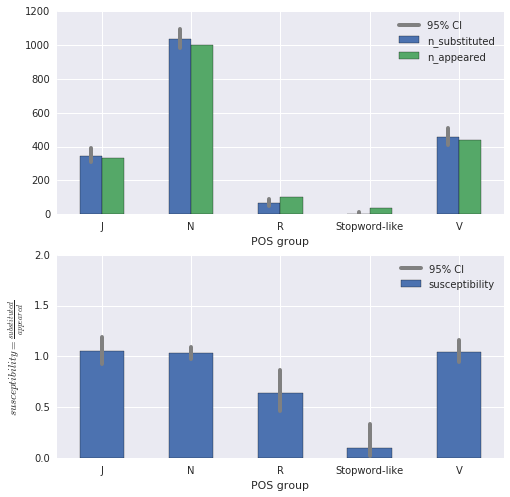

In [8]:
# Compute POS counts.
susties_pos = words[words.feature == 'aoa']\
    .groupby('rPOS')['target']\
    .aggregate({'susceptibility': susty_all,
                'n_substituted': target_all_counts,
                'n_appeared': appeared_all_counts})\
    .rename_axis('POS group')

# Plot.

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
# Raw substituted and appeared values.
susties_pos[['n_substituted', 'n_appeared']]\
    .plot(ax=axes[0], kind='bar', rot=0)
# With their CIs.
total_substituted = susties_pos.n_substituted.sum()
cis = multinomial_proportions_confint(susties_pos.n_substituted.round(),
                                      method='goodman')
for i in range(len(susties_pos)):
    axes[0].plot([i-.125, i-.125], cis[i] * total_substituted,
                 lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[0].legend()
# Substitutability values.
susties_pos['susceptibility']\
    .plot(ax=axes[1], kind='bar', legend=True, ylim=(0, 2), rot=0)
axes[1].set_ylabel(r'$susceptibility = \frac{substituted}{appeared}$')
# With their CIs.
for i in range(len(susties_pos)):
    axes[1].plot([i, i], (cis[i] * total_substituted 
                          / susties_pos.n_appeared.iloc[i]),
                 lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[1].legend(loc='best')
# Save if necessary.
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('all-susceptibilities-pos'),
                bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're in case (3) of the explanation below on confidence intervals (in section 3): it's really like a multinomial sampling, but not quite since not all POS tags are available to sample from in all the sentences. There's no way out of this, so we're going to use multinomial CIs. We can safely scale all the bars and CIs to their respective `n_appeared` values, since that is an independent given before the sampling.

**Are the appeared and substituted proportions statistically different?**

The only test we can easily do is a multinomial goodness-of-fit. This tells us if the `n_substituted` counts are significantly different from the reference `n_appeared` counts.

From there on we know a few things:
* Comparing a given POS's `n_substituted` count to its reference `n_appeared` count tells us if it's statistically different (< or >). We know this will be true individually for any POS that is out of its confidence region for the global goodness-of-fit test, since it's a weaker hypothesis (so the null rejection region will be wider, and the POS we're looking at is already in the rejection region for the global test). We don't know if it'll be true or not for POSes that are in their confidence region for the global test.
* Jointly comparing two POS's `n_substituted` counts to their reference `n_appeared` counts tells us if there is bias for one w.r.t. the other. This is also true for all pairs of POSes that are on alternate sides of their confidence region in the global test (for the same reasons as in the previous point). We don't know if it's true for the other POSes though.

In [9]:
# Test the n_substituted proportions are different from
# the n_appeared proportions
total_appeared = susties_pos.n_appeared.sum()
appeared_cis = multinomial_proportions_confint(
    susties_pos.n_appeared.round(), method='goodman')
differences = [(s < ci[0] * total_appeared) or (s > ci[1] * total_appeared)
               for s, ci in zip(susties_pos.n_substituted, appeared_cis)]
are_different = np.any(differences)
if are_different:
    print("Appeared and substituted proportions are different with p < .05")
    print("The following POS tags are out of their confidence region:",
          list(susties_pos.index[np.where(differences)[0]]))
else:
    print("Appeared and substituted proportions cannot be "
          "said different with p value better than .05")

Appeared and substituted proportions are different with p < .05
The following POS tags are out of their confidence region: ['R', 'Stopword-like']


## 3 On global feature values

Prepare plotting functions, for bin and quartile susceptibilities for each feature.

In [10]:
def print_significance(feature, h0s, heights):
    h0_total = h0s.sum()
    bin_count = len(h0s)
    print()
    print('-' * len(feature))
    print(feature)
    print('-' * len(feature))
    for n_stars, alpha in enumerate([.05, .01, .001]):
        h0_cis = multinomial_proportions_confint(h0s.round(),
                                                 method='goodman',
                                                 alpha=alpha)
        differences = ((heights < h0_cis[:, 0] * h0_total)
                       | (heights > h0_cis[:, 1] * h0_total))
        are_different = np.any(differences)
        stars = ' ' * (3 - n_stars) + '*' * (1 + n_stars)
        if are_different:
            bins_different = np.where(differences)[0]
            bins_different += np.ones_like(bins_different)
            print(stars + ' Target different H_0 with p < {}.'
                  ' Bins [1; {}] out of region: {}'
                  .format(alpha, bin_count, bins_different.tolist()))
        else:
            print('     Target NOT different from H_0 (p > {})'
                  .format(alpha))
            break

In [11]:
def plot_bin_susties(**kwargs):
    data = kwargs['data']
    feature = data.iloc[0].feature
    color = kwargs.get('color', 'blue')
    relative = kwargs.get('relative', False)
    quantiles = kwargs.get('quantiles', False)
    value = data.value_rel if relative else data.value
    
    # Compute binning.
    cut, cut_kws = ((pd.qcut, {}) if quantiles
                    else (pd.cut, {'right': False}))
    for bin_count in range(BIN_COUNT, 0, -1):
        try:
            value_bins, bins = cut(value, bin_count, labels=False,
                                   retbins=True, **cut_kws)
            break
        except ValueError:
            pass
    middles = (bins[:-1] + bins[1:]) / 2

    # Compute bin counts. Note here the bins are computed on the
    # distribution of observed substitutions, not the simulated aggregated
    # distributions of cluster-unit substitutions. But since it's mostly
    # deduplication that the aggregation process addresses, the bins
    # should be mostly the same. This could be corrected by computing
    # bins on the aggregate distribution (not hard), but it's really
    # not important now.
    heights = np.zeros(bin_count)
    h0s = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = (data[data.target & (value_bins == i)]
                      .weight_feature.sum())
        h0s[i] = data[value_bins == i].weight_feature_appeared.sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = (r'\sigma_{\phi'
                + ('_r' if relative else '')
                + '}')
    plt.plot(middles, heights / h0s, 
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(middles, np.ones_like(middles), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xlim(middles[0], middles[-1])
    plt.ylim(0, 2)
    
    # Test for statistical significance
    print_significance(feature, h0s, heights)

In [12]:
def plot_grid(data, features, filename,
              plot_function, xlabel, ylabel, plot_kws={}):
    g = sb.FacetGrid(data=data[data['feature']
                               .map(lambda f: f in features)],
                     sharex=False, sharey=True,
                     col='feature', hue='feature',
                     col_order=features, hue_order=features,
                     col_wrap=3, aspect=1.5, size=3)
    g.map_dataframe(plot_function, **plot_kws)
    g.set_titles('{col_name}')
    g.set_xlabels(xlabel)
    g.set_ylabels(ylabel)
    for ax in g.axes.ravel():
        legend = ax.legend(frameon=True, loc='best')
        if not legend:
            # Skip if nothing was plotted on these axes.
            continue
        frame = legend.get_frame()
        frame.set_facecolor('#f2f2f2')
        frame.set_edgecolor('#000000')
        ax.set_title(Substitution._transformed_feature(ax.get_title())
                     .__doc__)
    if SAVE_FIGURES:
        g.fig.savefig(settings.FIGURE.format(filename),
                      bbox_inches='tight', dpi=300)

### 3.1 Bins of distribution of appeared global feature values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2]
     Target NOT different from H_0 (p > 0.001)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [3]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


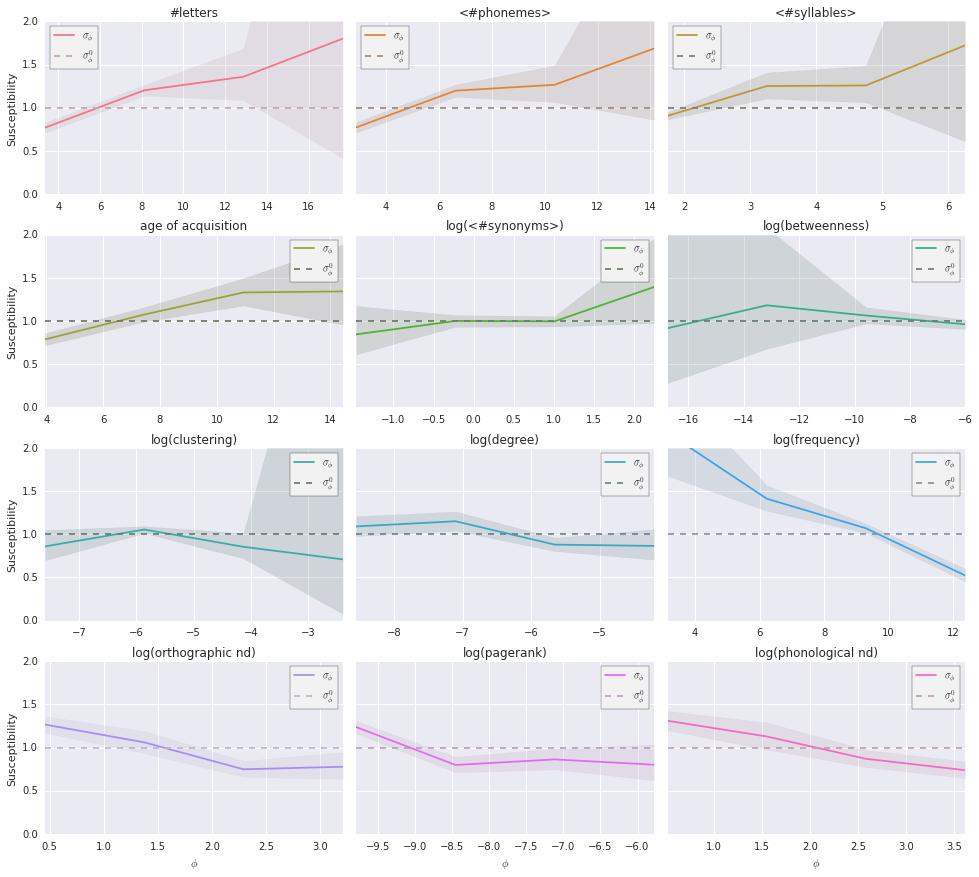

In [13]:
plot_grid(words, ordered_features,
          'all-susceptibilities-fixedbins_global',
          plot_bin_susties, r'$\phi$', 'Susceptibility')

**Note on how graphs and their confidence intervals are computed here**

There are three ways I can do a computation like above:

(1) For each word, we look at how many times it is substituted versus how many times it appears in a position where it could have been substituted. This is the *word*'s susceptibility, $\sigma(w)$. Then for each feature bin $b_i$ we take all the words such that $\phi(w) \in b_i$, average, and compute an asymptotic confidence interval based on how many words are in the bin. This fails for sentence-relative features, because a given word has different feature values depending on the sentence it appears in. So we discard this.

(2) Do the same but at the feature value level. So we define a *feature value* susceptibility, $\sigma_{\phi}(f)$, and compute a confidence interval based on how many different feature values we have in the bin. The idea behind (1) and (2) is to look at the bin middle-value like the relevant object we're measuring, and we have several measures for each bin middle-value, hence the confidence interval. In each bin $b_i$ we have:

$$\left< \sigma_{\phi}(f) \right>_{f \in b_i}$$

The problem with both (1) and (2) is that there's no proper $\mathcal{H}_0$ value, because the averages in the bins don't necessarily equal 1 under $\mathcal{H}_0$. Also, we can't check that there is consistency, showing that the sum of susceptibility values of the bins is 1. Hence case 3:

(3) Consider that we sample a multinomial process: each substitution is in fact the sampling of a feature value from one of the four bins. In that case, we can compute multinomial proportion CIs. This is also not completely satisfactory since in most cases not all feature values are available at the time of sampling, since most sentences don't range over all the feature's values, but it's what lets us compute proper null hypotheses: in each bin $b_i$ we have a value of $\sigma_{\phi}(b_i)$, and the sum of those should be the same under $\mathcal{H}_0$ as in the experiment (in practice in the graphs, we divide by the values under $\mathcal{H}_0$, and the reference is $\sigma_{\phi}^0(b_i) = 1$).

Here and below, we're always in case (3).


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [3, 4]



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


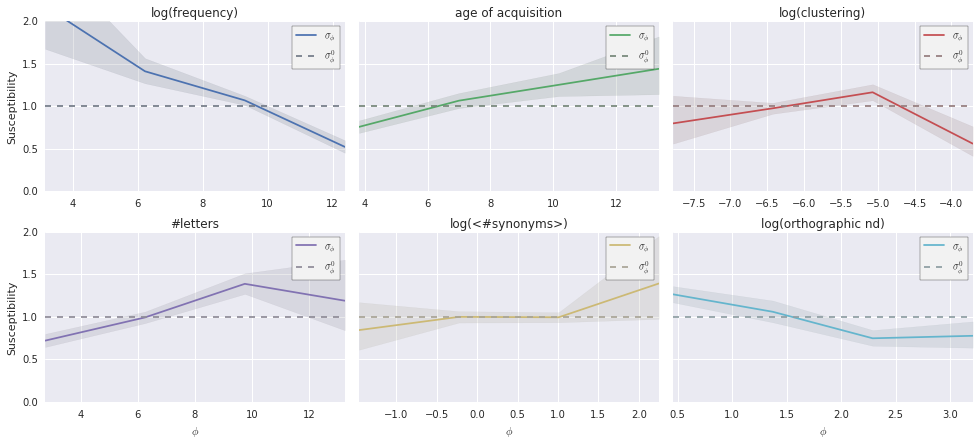

In [14]:
plot_grid(words[~(((words.feature == 'letters_count') 
                   & (words.value > 15))
                  | ((words.feature == 'aoa') 
                     & (words.value > 15))
                  | ((words.feature == 'clustering') 
                     & (words.value > -3)))],
          PAPER_FEATURES,
          'paper-susceptibilities-fixedbins_global',
          plot_bin_susties, r'$\phi$', 'Susceptibility')

### 3.2 Quantiles of distribution of appeared global feature values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 2] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 2] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 2] out of region: [1, 2]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3]
     Target NOT different from H_0 (p > 0.01)



-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3]
     Target NOT different from H_0 (p > 0.01)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]


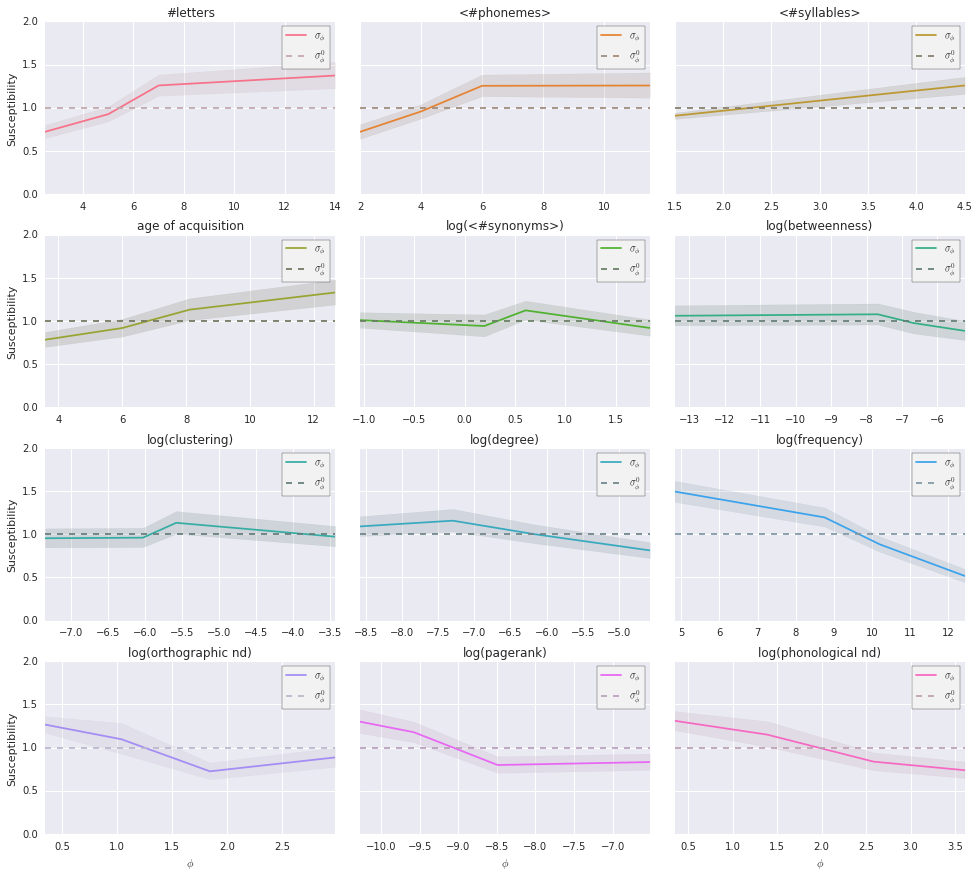

In [15]:
plot_grid(words, ordered_features,
          'all-susceptibilities-quantilebins_global', plot_bin_susties,
          r'$\phi$', 'Susceptibility',
          plot_kws={'quantiles': True})

**Note on confidence intervals**

Here we're again in case (2) of the above explanation on confidence intervals (in section 3.1), since we're just binning by quantiles instead of fixed-width bins.


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3]
     Target NOT different from H_0 (p > 0.01)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3]
     Target NOT different from H_0 (p > 0.01)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


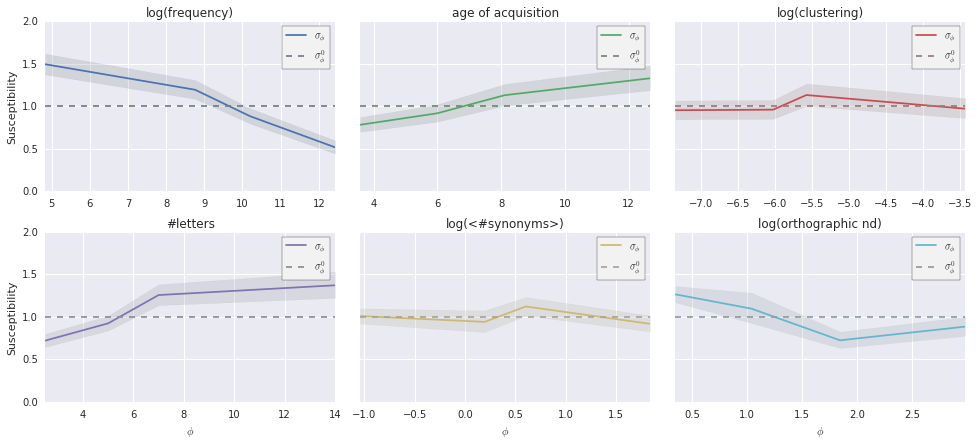

In [16]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-quantilebins_global', plot_bin_susties,
          r'$\phi$', 'Susceptibility',
          plot_kws={'quantiles': True})

## 4 On sentence-relative feature values

### 4.1 Bins of distribution of appeared sentence-relative values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


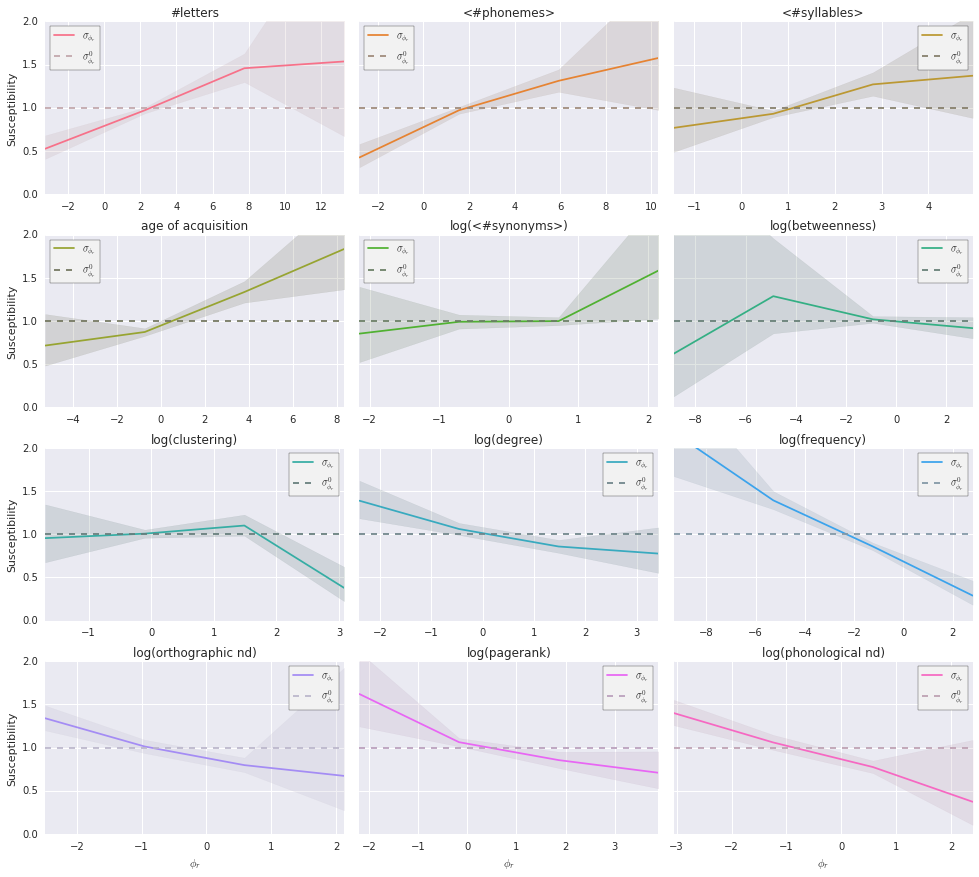

In [17]:
plot_grid(words, ordered_features,
          'all-susceptibilities-fixedbins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'relative': True})


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3, 4]



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


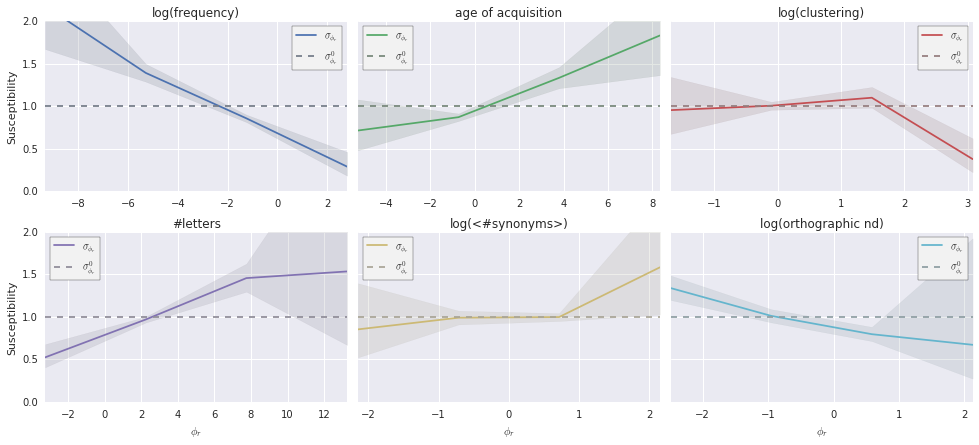

In [18]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-fixedbins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'relative': True})

### 4.2 Quantiles of distribution of appeared sentence-relative values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


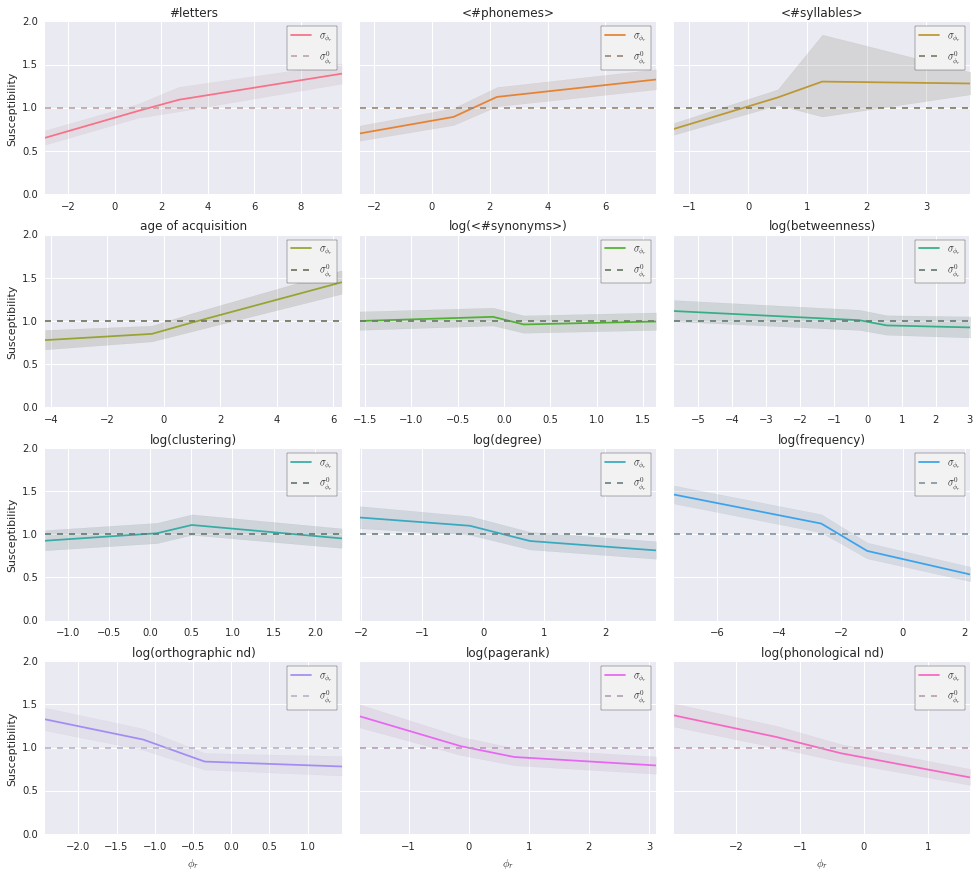

In [19]:
plot_grid(words, ordered_features,
          'all-susceptibilities-quantilebins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'quantiles': True, 'relative': True})


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]


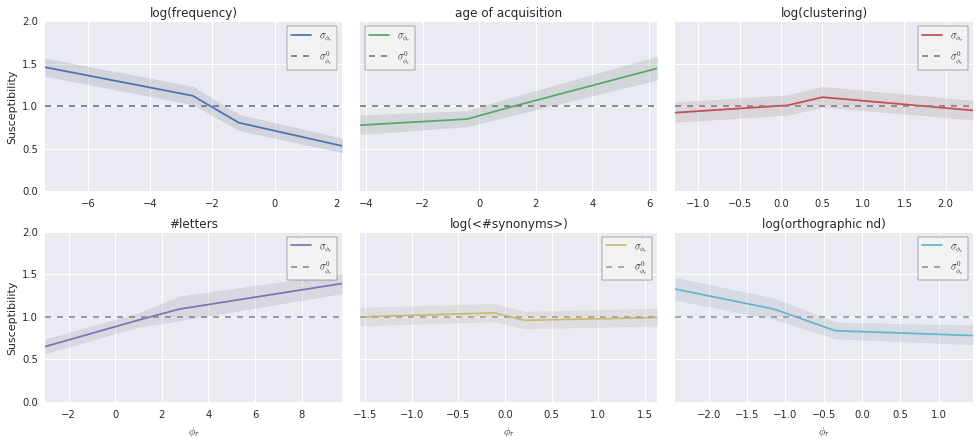

In [20]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-quantilebins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'quantiles': True, 'relative': True})

## 5 On quantiles and bins of the in-sentence distributions

### 5.1 In-sentence bins (of distribution of values in each sentence)

In [21]:
def plot_sentencebin_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    h0s = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = (data[data.target & (data.bin == i)]
                      .weight_feature.sum())
        h0s[i] = data[data.bin == i].weight_feature_appeared.sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{bin_{\phi}}'
    x = range(1, BIN_COUNT + 1)
    plt.plot(x, heights / h0s, color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, np.ones_like(x), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xticks(x)
    plt.ylim(0, None)
    
    # Test for significance.
    print_significance(feature, h0s, heights)


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
     Target NOT different from H_0 (p > 0.01)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


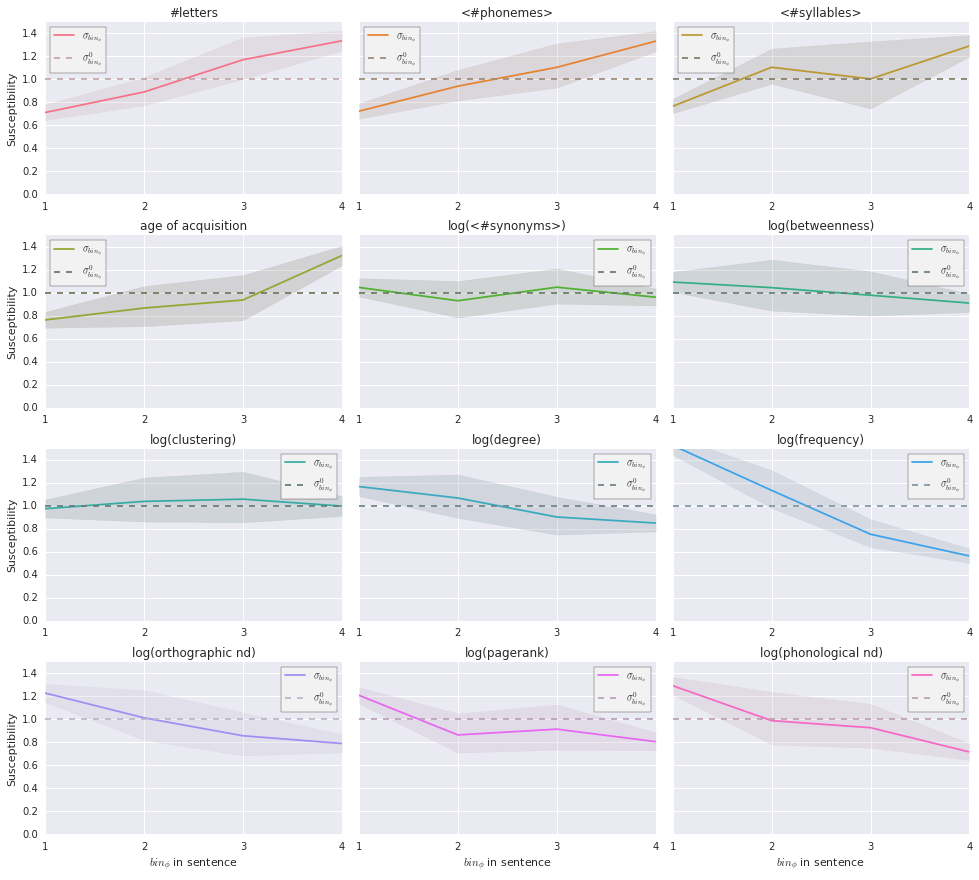

In [22]:
plot_grid(words, ordered_features,
          'all-susceptibilities-sentencebins',
          plot_sentencebin_susties, r'$bin_{\phi}$ in sentence',
          'Susceptibility')


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


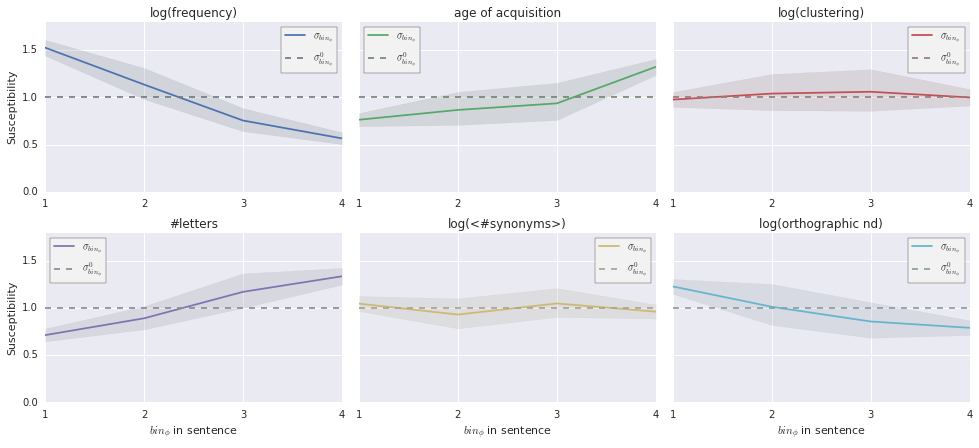

In [23]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-sentencebins',
          plot_sentencebin_susties, r'$bin_{\phi}$ in sentence',
          'Susceptibility')

### 5.2 In-sentence quantiles (of distribution of values in each sentence)

For each feature, count the sum of weights in each bin and plot that.

In [24]:
def bound(limits, values):
    left, right = limits
    assert left < right
    return np.maximum(left, np.minimum(right, values))

In [25]:
def plot_sentencequantile_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    h0s = np.zeros(BIN_COUNT)
    step = 1 / BIN_COUNT
    for i in range(BIN_COUNT):
        limits = [i * step, (i + 1) * step]
        contributions = ((bound(limits, data.stop_quantile)
                          - bound(limits, data.start_quantile))
                         / (data.stop_quantile - data.start_quantile))
        heights[i] = \
            (contributions * data.weight_feature)[data.target].sum()
        h0s[i] = (contributions * data.weight_feature_appeared).sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total)# / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{q_{\phi}}'
    x = range(1, BIN_COUNT + 1)
    plt.plot(x, heights,# / h0s,
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, h0s, '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xticks(x)
    plt.ylim(0, None)
    
    # Test for significance.
    print_significance(feature, h0s, heights)


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.01)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


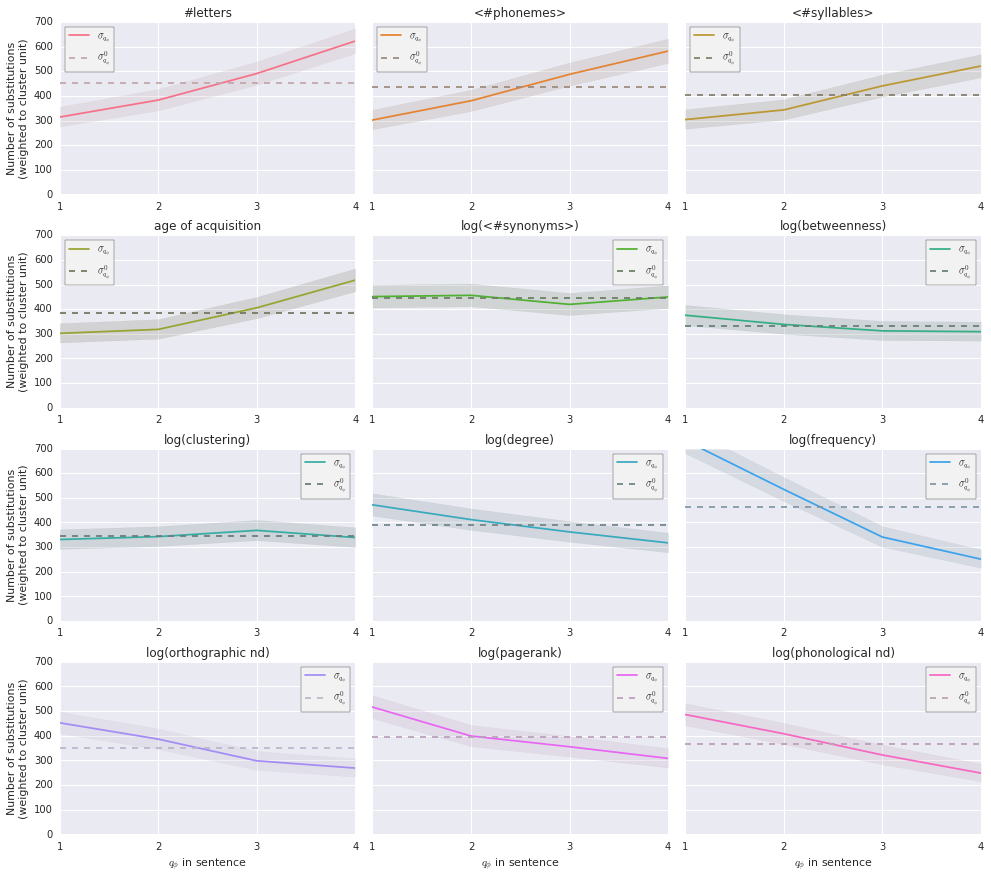

In [26]:
plot_grid(words, ordered_features,
          'all-susceptibilities-sentencequantiles',
          plot_sentencequantile_susties, r'$q_{\phi}$ in sentence',
          'Number of substitutions\n(weighted to cluster unit)')


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


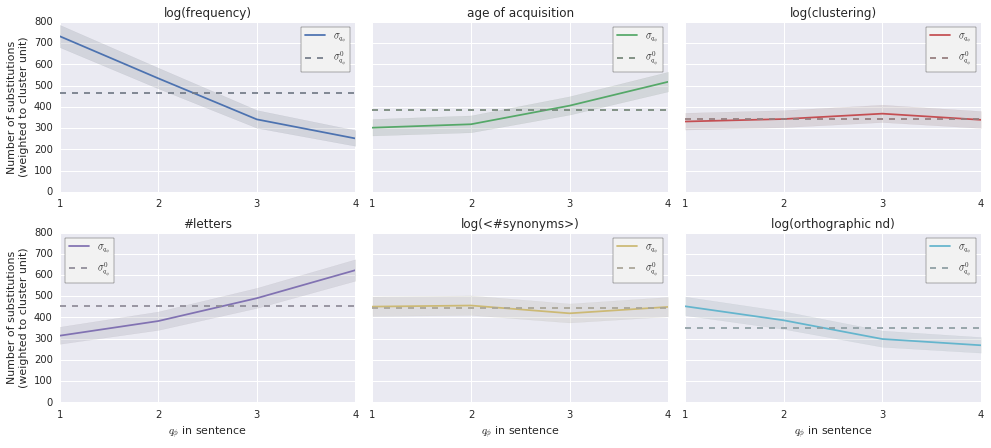

In [27]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-sentencequantiles',
          plot_sentencequantile_susties, r'$q_{\phi}$ in sentence',
          'Number of substitutions\n(weighted to cluster unit)')

## 6 Regression on significant features

### 6.1 Multinomial logistic regression

We try to predict which words are substituted, based on their global values, sentence-relative values, bins and quantiles of those, or in-sentence bin values.

Prediction is not good, mainly because the constraint of one-substitution-per-sentence can't be factored in the model simply. So precision is generally very low, around .20-.25, and when accuracy goes up recall plummets.

So it might show some interaction effects, but given that the fit is very bad I wouldn't trust it.

In-sentence quantiles (from section 5.2) were not done, as they're impossible to reduce to one value (our measure of those quantiles is in fact a subrange of [0, 1] for each word, corresponding to the subrange of the sentence distribution that that word's feature value represented).

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import binom_test

In [29]:
def regress_binning(data, features, value_funcs):
    # Compute bins
    data = data.copy()
    regress_features = [('{}'.format(value_name), feature)
                        for value_name in value_funcs.keys()
                        for feature in features]
    for i, (value_name, value_func) in enumerate(value_funcs.items()):
        data[value_name] = value_func(data)
    
    # Massage the dataframe to have feature bin as columns.
    data_wide = pd.pivot_table(
        data,
        values=list(value_funcs.keys()),
        index=['destination_id', 'occurrence', 'source_id', 'position',
               'word_position'],
        columns=['feature']
    )[regress_features]

    # Add the target value.
    # Question/FIXME: should we use weight_appeared for regression?
    data_wide['target'] = pd.pivot_table(
        data,
        values=['target'],
        index=['destination_id', 'occurrence', 'source_id', 'position',
               'word_position'],
        columns=['feature']
    )[('target', 'aoa')]
    data_wide = data_wide.dropna()

    # Compute polynomial features.
    poly = PolynomialFeatures(degree=2, interaction_only=True)
    pdata = poly.fit_transform(data_wide[regress_features])
    pregress_features = [' * '.join(['_'.join(regress_features[j])
                                   for j, p in enumerate(powers)
                                   if p > 0]) or 'intercept'
                         for powers in poly.powers_]

    # Divide into two sets.
    print('Regressing with {} word measures (divided into'
          ' training and prediction sets)'
          .format(len(data_wide)))
    pdata_train = pdata[:len(data_wide) // 2]
    target_train = data_wide.iloc[:len(data_wide) // 2].target
    pdata_predict = pdata[len(data_wide) // 2:]
    target_predict = data_wide.iloc[len(data_wide) // 2:].target
    assert len(pdata_train) + len(pdata_predict) == len(data_wide)
    assert len(target_train) + len(target_predict) == len(data_wide)
    
    # Regress
    regressor = LogisticRegression(penalty='l2', class_weight='balanced',
                                   fit_intercept=False)
    regressor.fit(pdata_train, target_train)
    
    # And predict
    prediction = regressor.predict(pdata_predict)
    standard = target_predict.values
    success = prediction == standard
    
    tp = prediction & standard
    tn = (~prediction) & (~standard)
    fp = prediction & (~standard)
    fn = (~prediction) & standard
    
    print()
    print('{:.2f}% of words well predicted (non-random at p = {:.1})'
          .format(100 * success.mean(),
                  binom_test(success.sum(), len(success))))
    print('Precision = {:.2f}'.format(standard[prediction].mean()))
    print('Recall = {:.2f}'.format(prediction[standard].mean()))
    print()
    print('Coefficients:')
    print(pd.Series(index=pregress_features, data=regressor.coef_[0]))

**Global feature value**

In [30]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'global': lambda d: d.value})

Regressing with 164217 word measures (divided into training and prediction sets)



57.26% of words well predicted (non-random at p = 1e-323)


Precision = 0.32
Recall = 0.58

Coefficients:
intercept                                             3.343443
global_frequency                                     -0.362514
global_aoa                                           -0.547383
global_letters_count                                  0.207862
global_orthographic_density                           0.144328
global_frequency * global_aoa                         0.060200
global_frequency * global_letters_count              -0.040318
global_frequency * global_orthographic_density        0.003758
global_aoa * global_letters_count                     0.017620
global_aoa * global_orthographic_density             -0.051941
global_letters_count * global_orthographic_density    0.062052
dtype: float64


**Sentence-relative feature value**

In [31]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'sentence-rel': lambda d: d.value_rel})

Regressing with 164217 word measures (divided into training and prediction sets)



60.79% of words well predicted (non-random at p = 1e-323)
Precision = 0.32
Recall = 0.50

Coefficients:
intercept                                                        -0.318631
sentence-rel_frequency                                           -0.148903
sentence-rel_aoa                                                  0.015283
sentence-rel_letters_count                                       -0.039957
sentence-rel_orthographic_density                                -0.029326
sentence-rel_frequency * sentence-rel_aoa                         0.023598
sentence-rel_frequency * sentence-rel_letters_count              -0.034346
sentence-rel_frequency * sentence-rel_orthographic_density       -0.002080
sentence-rel_aoa * sentence-rel_letters_count                     0.038838
sentence-rel_aoa * sentence-rel_orthographic_density              0.020525
sentence-rel_letters_count * sentence-rel_orthographic_density    0.053394
dtype: float64


**Global + sentence-relative feature values**

In [32]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'global': lambda d: d.value,
                 'sentence-rel': lambda d: d.value_rel})

Regressing with 164217 word measures (divided into training and prediction sets)



62.52% of words well predicted (non-random at p = 1e-323)
Precision = 0.35
Recall = 0.56

Coefficients:
intercept                                                         -0.481700
sentence-rel_frequency                                            -0.721328
sentence-rel_aoa                                                   0.138638
sentence-rel_letters_count                                        -0.034946
sentence-rel_orthographic_density                                  0.536210
global_frequency                                                   0.168103
global_aoa                                                        -0.901720
global_letters_count                                               0.489134
global_orthographic_density                                        0.826901
sentence-rel_frequency * sentence-rel_aoa                         -0.077099
sentence-rel_frequency * sentence-rel_letters_count               -0.042081
sentence-rel_frequency * sentence-rel_orthographic_density 

**(3.1) Bins of distribution of appeared global feature values**

In [33]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'bins-global':
                     lambda d: pd.cut(d.value, BIN_COUNT,
                                      labels=False, right=False)})

Regressing with 164217 word measures (divided into training and prediction sets)



64.84% of words well predicted (non-random at p = 1e-323)
Precision = 0.38
Recall = 0.63

Coefficients:
intercept                                                       0.251881
bins-global_frequency                                           0.097624
bins-global_aoa                                                -1.266303
bins-global_letters_count                                       0.022710
bins-global_orthographic_density                                0.474632
bins-global_frequency * bins-global_aoa                         0.973378
bins-global_frequency * bins-global_letters_count              -0.766857
bins-global_frequency * bins-global_orthographic_density       -0.618048
bins-global_aoa * bins-global_letters_count                     0.244898
bins-global_aoa * bins-global_orthographic_density             -0.682130
bins-global_letters_count * bins-global_orthographic_density    1.170140
dtype: float64


**(3.2) Quantiles of distribution of appeared global feature values**

In [34]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'quantiles-global':
                     lambda d: pd.qcut(d.value, BIN_COUNT, labels=False)})

Regressing with 164217 word measures (divided into training and prediction sets)



55.47% of words well predicted (non-random at p = 3e-216)
Precision = 0.32
Recall = 0.66

Coefficients:
intercept                                                                 2.742018
quantiles-global_frequency                                               -2.628936
quantiles-global_aoa                                                     -1.289167
quantiles-global_letters_count                                            4.317996
quantiles-global_orthographic_density                                    -2.267747
quantiles-global_frequency * quantiles-global_aoa                         0.874983
quantiles-global_frequency * quantiles-global_letters_count              -0.789338
quantiles-global_frequency * quantiles-global_orthographic_density        1.412927
quantiles-global_aoa * quantiles-global_letters_count                    -0.425390
quantiles-global_aoa * quantiles-global_orthographic_density             -0.223808
quantiles-global_letters_count * quantiles-global_orthographic_de

**(4.1) Bins of distribution of appeared sentence-relative values**

In [35]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'bins-sentence-rel':
                     lambda d: pd.cut(d.value_rel, BIN_COUNT,
                                      labels=False, right=False)})

Regressing with 164217 word measures (divided into training and prediction sets)



71.50% of words well predicted (non-random at p = 1e-323)
Precision = 0.41
Recall = 0.28

Coefficients:
intercept                                                                   0.902856
bins-sentence-rel_frequency                                                -0.678447
bins-sentence-rel_aoa                                                      -0.430208
bins-sentence-rel_letters_count                                            -0.425241
bins-sentence-rel_orthographic_density                                      0.902856
bins-sentence-rel_frequency * bins-sentence-rel_aoa                         0.100913
bins-sentence-rel_frequency * bins-sentence-rel_letters_count               0.349970
bins-sentence-rel_frequency * bins-sentence-rel_orthographic_density       -0.678447
bins-sentence-rel_aoa * bins-sentence-rel_letters_count                     0.630329
bins-sentence-rel_aoa * bins-sentence-rel_orthographic_density             -0.430208
bins-sentence-rel_letters_count * bins-senten

**(4.2) Quantiles of distribution of appeared sentence-relative values**

In [36]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'quantiles-sentence-rel':
                     lambda d: pd.qcut(d.value_rel, BIN_COUNT,
                                       labels=False)})

Regressing with 164217 word measures (divided into training and prediction sets)



48.52% of words well predicted (non-random at p = 3e-17)
Precision = 0.28
Recall = 0.65

Coefficients:
intercept                                                                             0.080587
quantiles-sentence-rel_frequency                                                     -0.052984
quantiles-sentence-rel_aoa                                                           -0.278743
quantiles-sentence-rel_letters_count                                                  0.000389
quantiles-sentence-rel_orthographic_density                                           0.018122
quantiles-sentence-rel_frequency * quantiles-sentence-rel_aoa                         0.186382
quantiles-sentence-rel_frequency * quantiles-sentence-rel_letters_count              -0.247670
quantiles-sentence-rel_frequency * quantiles-sentence-rel_orthographic_density        0.020872
quantiles-sentence-rel_aoa * quantiles-sentence-rel_letters_count                     0.119942
quantiles-sentence-rel_aoa * quantiles-se

**(5.1) In-sentence bins (of distribution of values in each sentence)**

In [37]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'in-sentence-bins': lambda d: d.bin})

Regressing with 164217 word measures (divided into training and prediction sets)



66.90% of words well predicted (non-random at p = 1e-323)
Precision = 0.40
Recall = 0.61

Coefficients:
intercept                                                                -0.496654
in-sentence-bins_frequency                                               -0.178936
in-sentence-bins_aoa                                                      0.172653
in-sentence-bins_letters_count                                            0.316749
in-sentence-bins_orthographic_density                                     0.314365
in-sentence-bins_frequency * in-sentence-bins_aoa                        -0.002662
in-sentence-bins_frequency * in-sentence-bins_letters_count              -0.104625
in-sentence-bins_frequency * in-sentence-bins_orthographic_density       -0.016064
in-sentence-bins_aoa * in-sentence-bins_letters_count                     0.005941
in-sentence-bins_aoa * in-sentence-bins_orthographic_density             -0.017442
in-sentence-bins_letters_count * in-sentence-bins_orthographic_de

### 6.2 PCA

We get coefficient values out of the PCA, but I can't figure what to make of them... They reflect the correlations of the features, alright, but beyond that? Some interactions, but there's no clear interpretation of the coefficients and variances explained into interaction strengths.

In [38]:
from sklearn.decomposition import PCA

In [39]:
def pca_values(data, features, value_func):
    data = data.copy()
    data['pca_value'] = value_func(data)
    
    # Prepare dataframe, averaging over shared durl.
    data_wide = pd.pivot_table(
        data[data.target],
        values='pca_value',
        index=['cluster_id', 'destination_id', 'occurrence',
               'position'],
        columns=['feature']
    )[features]
    # ... then over shared clusters, and dropping NaNs.
    data_wide = data_wide\
        .groupby(level='cluster_id')\
        .agg(np.mean)\
        .dropna(how='any')
    print('Computing PCA on {} aggregated word measures'
          .format(len(data_wide)))
    print()
    
    # Compute PCA.
    pca = PCA(n_components='mle')
    pca.fit(data_wide)
    print('Variance explained by first {} components (mle-estimated): {}'
          .format(pca.n_components_, pca.explained_variance_ratio_))
    print()
    print('Components:')
    print(pd.DataFrame(index=data_wide.columns,
                       data=pca.components_.T,
                       columns=['Comp. {}'.format(i)
                                for i in range(pca.n_components_)]))

**PCA of feature value of substituted words**

In [40]:
pca_values(words, ['frequency', 'aoa', 'letters_count'],
           lambda d: d.value)

Computing PCA on 1506 aggregated word measures



Variance explained by first 2 components (mle-estimated): [ 0.68493472  0.18098882]

Components:
                Comp. 0   Comp. 1
feature                          
frequency     -0.380000  0.576279
aoa            0.741482 -0.277860
letters_count  0.552995  0.768568


**PCA of sentence-relative value of substituted words**

In [41]:
pca_values(words, ['frequency', 'aoa', 'letters_count'],
           lambda d: d.value_rel)

Computing PCA on 1506 aggregated word measures

Variance explained by first 1 components (mle-estimated): [ 0.63041865]

Components:
                Comp. 0
feature                
frequency     -0.499677
aoa            0.661912
letters_count  0.558745
